In [7]:
!pip install pickle5

     |████████████████████████████████| 256 kB 10.7 MB/s 


In [2]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 3.8 MB 31.1 MB/s 
     |████████████████████████████████| 448 kB 44.1 MB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=da208b6c8fb8b6be0ce38d34e98c89010b0dbe8dba7378c8e841853c9114040c
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [3]:
!pip install h5py==2.10.0

     |████████████████████████████████| 2.9 MB 4.0 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


## imports

In [10]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle5 as pickle
from IPython.display import HTML

In [11]:
import nltk
from nltk.corpus import stopwords

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Bidirectional, Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input, Embedding, LeakyReLU, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tensorflow.__version__

'2.1.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## load data

In [4]:
!cp /content/drive/MyDrive/DAI_Project/* /content/

cp: cannot open '/content/drive/MyDrive/DAI_Project/bias_free_logs_alpha=-0.5.gsheet' for reading: Operation not supported
cp: -r not specified; omitting directory '/content/drive/MyDrive/DAI_Project/saved_models'


In [14]:
# df_movies = pd.read_pickle("df_movie.pkl")
# print(df_movies.shape)
# df_movies.head()

with open("df_movie.pkl", "rb") as f:
  df_movies = pickle.load(f)
df_movies.head()

,rating,title,year,votes,top 250 rank,kind,top indian 250 rank,bottom 100 rank
0111161,9.2,The Shawshank Redemption,1994,2497651,1,movie,NaN,NaN
0068646,9.1,The Godfather,1972,1722236,2,movie,NaN,NaN
0071562,9,The Godfather: Part II,1974,1195394,3,movie,NaN,NaN
0468569,9,The Dark Knight,2008,2448173,4,movie,NaN,NaN
0050083,8.9,12 Angry Men,1957,737820,5,movie,NaN,NaN


In [15]:
# df_reviews = pd.read_pickle("df_reviews.pkl")
# print(df_reviews.shape)
# df_reviews.head()

with open("df_reviews.pkl", "rb") as f:
  df_reviews = pickle.load(f)
df_reviews.head()

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link
0,0111161,The Shawshank Redemption,"Enthralling, fantastic, intriguing, truly rema...",Shawshank Redemption is without doubt one of t...,10/10,57 out of 87 found this helpful.,https://www.imdb.com//review/rw2053711/
1,0111161,The Shawshank Redemption,"""I Had To Go To Prison To Learn To Be A Crook""",None of the usual otherworld creatures that po...,9/10,17 out of 27 found this helpful.,https://www.imdb.com//review/rw2387096/
2,0111161,The Shawshank Redemption,All-time prison film classic,"Based on a novella by Stephen King, this is be...",10/10,8 out of 11 found this helpful.,https://www.imdb.com//review/rw3601108/
3,0111161,The Shawshank Redemption,Freeman gives it depth,Andy Dufresne (Tim Robbins) is a banker convic...,8/10,13 out of 23 found this helpful.,https://www.imdb.com//review/rw2918939/
4,0111161,The Shawshank Redemption,An incredible movie. One that lives with you.,It is no wonder that the film has such a high ...,10/10,12 out of 16 found this helpful.,https://www.imdb.com//review/rw6606154/


In [16]:
# df_movie_data = pd.read_pickle("df_movie_data.pkl")
# print(df_movie_data.shape)
# df_movie_data.head()

with open("df_movie_data.pkl", "rb") as f:
  df_movie_data = pickle.load(f)
df_movie_data.head()

,rating,title,year,votes,top 250 rank,kind,localized title,genre,cast,runtimes,languages,directors,writers,cover url,box office,top indian 250 rank,bottom 100 rank
0111161,9.2,The Shawshank Redemption,1994,2497651,1,movie,The Shawshank Redemption,[Drama],"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",[142],[English],[Frank Darabont],"[Stephen King, None, Frank Darabont]",https://m.media-amazon.com/images/M/MV5BMDFkYT...,"{'Budget': '$25,000,000 (estimated)', 'Opening...",NaN,NaN
0068646,9.1,The Godfather,1972,1722236,2,movie,The Godfather,"[Crime, Drama]","[Marlon Brando, Al Pacino, James Caan, Richard...",[175],"[English, Italian, Latin]",[Francis Ford Coppola],"[Mario Puzo, Francis Ford Coppola, None, Mario...",https://m.media-amazon.com/images/M/MV5BM2MyNj...,"{'Budget': '$6,000,000 (estimated)', 'Opening ...",NaN,NaN
0071562,9,The Godfather: Part II,1974,1195394,3,movie,The Godfather: Part II,"[Crime, Drama]","[Al Pacino, Robert Duvall, Diane Keaton, Rober...",[202],"[English, Italian, Spanish, Latin, Sicilian]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo, None, Mario...",https://m.media-amazon.com/images/M/MV5BMWMwMG...,"{'Budget': '$13,000,000 (estimated)', 'Opening...",NaN,NaN
0468569,9,The Dark Knight,2008,2448173,4,movie,The Dark Knight,"[Action, Crime, Drama, Thriller]","[Christian Bale, Heath Ledger, Aaron Eckhart, ...",[152],"[English, Mandarin]",[Christopher Nolan],"[Jonathan Nolan, Christopher Nolan, None, Chri...",https://m.media-amazon.com/images/M/MV5BMTMxNT...,"{'Budget': '$185,000,000 (estimated)', 'Openin...",NaN,NaN
0050083,8.9,12 Angry Men,1957,737820,5,movie,12 Angry Men,"[Crime, Drama]","[Martin Balsam, John Fiedler, Lee J. Cobb, E.G...",[96],[English],[Sidney Lumet],"[Reginald Rose, None, Reginald Rose]",https://m.media-amazon.com/images/M/MV5BMWU4N2...,"{'Budget': '$350,000 (estimated)'}",NaN,NaN


In [17]:
df_movie_data["m_id"] = df_movie_data.index.tolist()
df_movie_data.head()

,rating,title,year,votes,top 250 rank,kind,localized title,genre,cast,runtimes,languages,directors,writers,cover url,box office,top indian 250 rank,bottom 100 rank,m_id
0111161,9.2,The Shawshank Redemption,1994,2497651,1,movie,The Shawshank Redemption,[Drama],"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",[142],[English],[Frank Darabont],"[Stephen King, None, Frank Darabont]",https://m.media-amazon.com/images/M/MV5BMDFkYT...,"{'Budget': '$25,000,000 (estimated)', 'Opening...",NaN,NaN,0111161
0068646,9.1,The Godfather,1972,1722236,2,movie,The Godfather,"[Crime, Drama]","[Marlon Brando, Al Pacino, James Caan, Richard...",[175],"[English, Italian, Latin]",[Francis Ford Coppola],"[Mario Puzo, Francis Ford Coppola, None, Mario...",https://m.media-amazon.com/images/M/MV5BM2MyNj...,"{'Budget': '$6,000,000 (estimated)', 'Opening ...",NaN,NaN,0068646
0071562,9,The Godfather: Part II,1974,1195394,3,movie,The Godfather: Part II,"[Crime, Drama]","[Al Pacino, Robert Duvall, Diane Keaton, Rober...",[202],"[English, Italian, Spanish, Latin, Sicilian]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo, None, Mario...",https://m.media-amazon.com/images/M/MV5BMWMwMG...,"{'Budget': '$13,000,000 (estimated)', 'Opening...",NaN,NaN,0071562
0468569,9,The Dark Knight,2008,2448173,4,movie,The Dark Knight,"[Action, Crime, Drama, Thriller]","[Christian Bale, Heath Ledger, Aaron Eckhart, ...",[152],"[English, Mandarin]",[Christopher Nolan],"[Jonathan Nolan, Christopher Nolan, None, Chri...",https://m.media-amazon.com/images/M/MV5BMTMxNT...,"{'Budget': '$185,000,000 (estimated)', 'Openin...",NaN,NaN,0468569
0050083,8.9,12 Angry Men,1957,737820,5,movie,12 Angry Men,"[Crime, Drama]","[Martin Balsam, John Fiedler, Lee J. Cobb, E.G...",[96],[English],[Sidney Lumet],"[Reginald Rose, None, Reginald Rose]",https://m.media-amazon.com/images/M/MV5BMWU4N2...,"{'Budget': '$350,000 (estimated)'}",NaN,NaN,0050083


## rating process

In [14]:
df_reviews.review_rating.value_counts()

10/10    3357
8/10     2409
9/10     2206
7/10     1464
6/10      895
1/10      881
5/10      475
3/10      460
4/10      408
2/10      404
Name: review_rating, dtype: int64

In [18]:
def rating_to_class(rating):
    # 8/10
    rating = int(rating.split("/")[0])
    if rating <= 5:
        return "bad"
    elif rating <= 7:
        return "average"
    return "good"

def rating_to_class_binary(rating):
    # 8/10
    rating = int(rating.split("/")[0])
    if rating <= 6:
        return "bad"
    return "good"

df_reviews["review_class"] = df_reviews.review_rating.apply(lambda x: rating_to_class(x))
df_reviews["review_class_int"] = df_reviews.review_class.map({"bad": 0, "average":1, "good":2})

df_reviews["review_class_bin"] = df_reviews.review_rating.apply(lambda x: rating_to_class_binary(x))
df_reviews["review_class_bin_int"] = df_reviews.review_class_bin.map({"bad": 0, "good":1})

print(df_reviews.review_class.value_counts())
print(df_reviews.review_class_bin.value_counts())

good       7972
bad        2628
average    2359
Name: review_class, dtype: int64
good    9436
bad     3523
Name: review_class_bin, dtype: int64


In [22]:
df_reviews.head()

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int
0,0111161,The Shawshank Redemption,"Enthralling, fantastic, intriguing, truly rema...",Shawshank Redemption is without doubt one of t...,10/10,57 out of 87 found this helpful.,https://www.imdb.com//review/rw2053711/,good,2,good,1
1,0111161,The Shawshank Redemption,"""I Had To Go To Prison To Learn To Be A Crook""",None of the usual otherworld creatures that po...,9/10,17 out of 27 found this helpful.,https://www.imdb.com//review/rw2387096/,good,2,good,1
2,0111161,The Shawshank Redemption,All-time prison film classic,"Based on a novella by Stephen King, this is be...",10/10,8 out of 11 found this helpful.,https://www.imdb.com//review/rw3601108/,good,2,good,1
3,0111161,The Shawshank Redemption,Freeman gives it depth,Andy Dufresne (Tim Robbins) is a banker convic...,8/10,13 out of 23 found this helpful.,https://www.imdb.com//review/rw2918939/,good,2,good,1
4,0111161,The Shawshank Redemption,An incredible movie. One that lives with you.,It is no wonder that the film has such a high ...,10/10,12 out of 16 found this helpful.,https://www.imdb.com//review/rw6606154/,good,2,good,1


## genre process

In [ ]:
df_movie_data.sample(3)

,rating,title,year,votes,top 250 rank,kind,localized title,genre,cast,runtimes,languages,directors,writers,cover url,box office,top indian 250 rank,bottom 100 rank,m_id
0093578,7.7,Mr. India,1987,14918,NaN,movie,Mr. India,"[Action, Comedy, Drama, Family, Musical, Sci-Fi]","[Anil Kapoor, Sridevi, Amrish Puri, Satish Kau...",[179],[Hindi],[Shekhar Kapur],"[Javed Akhtar, None, Salim Khan]",https://m.media-amazon.com/images/M/MV5BZTdhMm...,None,213,NaN,0093578
1883367,3.1,The Human Centipede III (Final Sequence),2015,16066,NaN,movie,The Human Centipede III (Final Sequence),"[Comedy, Horror]","[Dieter Laser, Laurence R. Harvey, Eric Robert...",[102],[English],[Tom Six],[Tom Six],https://m.media-amazon.com/images/M/MV5BMzU1OT...,None,NaN,33,1883367
1517561,7.9,Thulladha Manamum Thullum,1999,5469,NaN,movie,Thulladha Manamum Thullum,"[Drama, Romance]","[Joseph Vijay, Simran, Dhamu, Vaiyapuri, Madha...",[170],[Tamil],[Ezhil],[Ezhil],https://m.media-amazon.com/images/M/MV5BODlhYT...,None,180,NaN,1517561


In [23]:
df_reviews = pd.merge(df_reviews, df_movie_data[["m_id", "rating", "genre"]], how = "inner", on="m_id")
print(df_reviews.shape)
df_reviews.sample(10)

(12912, 13)


,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre
1604,8267604,Capernaum,Zain steals our heart,Greetings again from the darkness. Rare is the...,8/10,5 out of 11 found this helpful.,https://www.imdb.com//review/rw4618969/,good,2,good,1,8.3,[Drama]
7697,0214915,Manichithrathazhu,one of the most interesting horror-thriller movie,"Ganga, who heard the fairy tale and fairy tale...",10/10,1 out of 2 found this helpful.,https://www.imdb.com//review/rw4021318/,good,2,good,1,8.5,"[Comedy, Horror, Music, Mystery, Thriller]"
95,0050083,12 Angry Men,12 Angry Men,I should start by saying that twelve is my fav...,9/10,1 out of 5 found this helpful.,https://www.imdb.com//review/rw2438916/,good,2,good,1,8.9,"[Crime, Drama]"
1168,0032553,The Great Dictator,Too soon?,Bumbling Jewish soldier (Charlie Chaplin) was ...,7/10,1 out of 6 found this helpful.,https://www.imdb.com//review/rw2983051/,average,1,good,1,8.4,"[Comedy, Drama, War]"
4749,1028532,Hachi: A Dog's Tale,Hachi: A Dog's Tale,I remember seeing the trailer for this film in...,6/10,0 out of 85 found this helpful.,https://www.imdb.com//review/rw3710413/,average,1,bad,0,8,"[Biography, Drama, Family]"
10966,0296574,Company,One of the best Gangster films,"RGV after making SHIVA, SATYA came back with a...",7/10,0 out of 2 found this helpful.,https://www.imdb.com//review/rw2500940/,average,1,good,1,7.9,"[Action, Crime, Drama, Thriller]"
6781,0295427,The Master of Disguise,Lamentably limp,I was aware of The Master of Disguise's dubiou...,1/10,2 out of 3 found this helpful.,https://www.imdb.com//review/rw2407267/,bad,0,bad,0,3.6,"[Adventure, Comedy, Family, Fantasy]"
7090,10481868,Black Christmas,Crude Stereotyping,"Filmed at the University of Otago, N.Z. hopefu...",2/10,4 out of 7 found this helpful.,https://www.imdb.com//review/rw6050823/,bad,0,bad,0,3.7,"[Horror, Mystery, Thriller]"
6618,0462244,Daddy Day Camp,Yes it's horrible but not bad to the point of ...,This is one of those Hollywood projects that m...,1/10,1 out of 2 found this helpful.,https://www.imdb.com//review/rw5352676/,bad,0,bad,0,3.5,"[Comedy, Family]"
10023,0488414,Omkara,Another excellent Shakespeare adaptation by Bh...,Another excellent Shakespeare adaptation by Bh...,9/10,0 out of 0 found this helpful.,https://www.imdb.com//review/rw3014892/,good,2,good,1,8,"[Action, Crime, Drama, Thriller]"


In [24]:
SEED = 42

df_review_data = df_reviews.sample(frac=1, random_state=SEED)
df_review_data = pd.concat([df_review_data[df_review_data.review_class == "good"][:3000],
                            df_review_data[df_review_data.review_class == "average"][:2000],
                            df_review_data[df_review_data.review_class == "bad"][:2500]]
                          )

df_review_data = df_review_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_review_data.shape)
print(df_review_data.review_class.value_counts())
print(df_review_data.review_class_bin.value_counts())

df_review_data.head()

(7500, 13)
good       3000
bad        2500
average    2000
Name: review_class, dtype: int64
good    4239
bad     3261
Name: review_class_bin, dtype: int64


,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre
0,0047478,Seven Samurai,There's Not One Thing Wrong with This Film,If you think a three-hour Japanese movie from ...,10/10,13 out of 27 found this helpful.,https://www.imdb.com//review/rw1448252/,good,2,good,1,8.6,"[Action, Adventure, Drama]"
1,0118688,Batman & Robin,"Bad man, really bad",Oh Dear. Oh Dear.Joel Schumacher had previousl...,1/10,3 out of 5 found this helpful.,https://www.imdb.com//review/rw2841618/,bad,0,bad,0,3.8,"[Action, Sci-Fi]"
2,2582802,Whiplash,Sticks And Stones ...,I'm going to aim for a little perspective here...,10/10,3 out of 7 found this helpful.,https://www.imdb.com//review/rw3167982/,good,2,good,1,8.5,"[Drama, Music]"
3,0118665,Baby Geniuses,About as awful as you'd think,This is one of the most legendary bad movies e...,1/10,5 out of 12 found this helpful.,https://www.imdb.com//review/rw4136680/,bad,0,bad,0,2.9,"[Comedy, Crime, Family, Sci-Fi]"
4,0367110,Swades,Way too long for the story it tells,Why is it that Indian filmmakers seem to belie...,4/10,11 out of 38 found this helpful.,https://www.imdb.com//review/rw1061977/,bad,0,bad,0,8.1,"[Drama, Musical]"


In [25]:
# take main genre
df_review_data["genre_primary"] = df_review_data["genre"].apply(lambda x: x[0])
df_review_data.sample(5)

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre,genre_primary
2036,2350496,The Lunchbox,Wonderful!,"Written & Directed by Ritesh Batra, 'The Lunch...",9/10,0 out of 0 found this helpful.,https://www.imdb.com//review/rw2974170/,good,2,good,1,7.8,"[Drama, Romance]",Drama
361,0167261,The Lord of the Rings: The Two Towers,My Visit To The Cinema,Don`t you just hate cinemas ? No matter where ...,9/10,31 out of 41 found this helpful.,https://www.imdb.com//review/rw0586146/,good,2,good,1,8.7,"[Action, Adventure, Drama, Fantasy]",Action
4203,0468569,The Dark Knight,Dark Knight-Joker and Others Go Wild ***,The film is good but is very much over-rated. ...,7/10,3 out of 16 found this helpful.,https://www.imdb.com//review/rw1925442/,average,1,good,1,9,"[Action, Crime, Drama, Thriller]",Action
2098,7668842,Enes Batur,disgrace,It is the worst movie ever in Turkish cinema h...,1/10,59 out of 70 found this helpful.,https://www.imdb.com//review/rw4043720/,bad,0,bad,0,2.9,[Comedy],Comedy
1946,0361748,Inglourious Basterds,Inglorious Basterds,"With brilliant films like Reservoir Dogs, Pulp...",6/10,2 out of 38 found this helpful.,https://www.imdb.com//review/rw2120052/,average,1,bad,0,8.3,"[Adventure, Drama, War]",Adventure


In [26]:
df_review_data.genre_primary.value_counts()

Action       2221
Comedy       1622
Drama        1484
Crime         739
Adventure     452
Biography     363
Animation     295
Horror        187
Mystery        96
Western        26
Thriller        9
Film-Noir       6
Name: genre_primary, dtype: int64

In [27]:
genre_dict = {'Action':'action', 'Comedy':'comedy', 'Drama':'drama', 
             "Crime":'thriller/crime', 'Adventure':'adventure', 'Biography':'biography',
             'Animation':'animation', 'Horror':'horror', 'Mystery':'thriller/crime', 'Western':'western', 'Thriller':'thriller/crime',
             'Film-Noir':'thriller/crime'
            }

df_review_data["genre_primary_mapped"] = df_review_data.genre_primary.map(genre_dict)

In [28]:
df_review_data.sample(10)

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre,genre_primary,genre_primary_mapped
3354,0804492,The Hottie & the Nottie,Paris Hilton tries and fails to headline a mov...,Nate Cooper (Joel David Moore) is an unemploye...,2/10,0 out of 1 found this helpful.,https://www.imdb.com//review/rw6866972/,bad,0,bad,0,2.2,"[Comedy, Romance]",Comedy,comedy
6477,0107290,Jurassic Park,"A child's fantasy, but the world's nightmare.","When man messes with the secrets of nature, th...",10/10,4 out of 5 found this helpful.,https://www.imdb.com//review/rw3460612/,good,2,good,1,8.1,"[Action, Adventure, Sci-Fi, Thriller]",Action,action
3563,0372873,Dragon Wars: D-War,"not too shabby,in my opinion(but what do i know?)","maybe i need to have my head examined,but i th...",7/10,1 out of 2 found this helpful.,https://www.imdb.com//review/rw1801281/,average,1,good,1,3.8,"[Action, Drama, Fantasy, Horror, Thriller]",Action,action
4553,0110978,Texas Chainsaw Massacre: The Next Generation,Texas Chainsaw Massacre:The New Generation,Sick-in-the-head sequel to the Texas Chainsaw ...,2/10,4 out of 12 found this helpful.,https://www.imdb.com//review/rw1686377/,bad,0,bad,0,3.6,"[Comedy, Horror, Thriller]",Comedy,comedy
3170,0253474,The Pianist,non-heroism,It's 1939 Warsaw. Wladyslaw Szpilman (Adrien B...,7/10,0 out of 10 found this helpful.,https://www.imdb.com//review/rw3547407/,average,1,good,1,8.5,"[Biography, Drama, Music, War]",Biography,biography
4104,0462244,Daddy Day Camp,God-awful Family Film with Little to Offer,After sitting through the entirety of Daddy Da...,2/10,80 out of 117 found this helpful.,https://www.imdb.com//review/rw1708684/,bad,0,bad,0,3.5,"[Comedy, Family]",Comedy,comedy
1352,0266697,Kill Bill: Vol. 1,Someone must be in between,Did everyone either love this or despise it? I...,5/10,4 out of 10 found this helpful.,https://www.imdb.com//review/rw1304626/,bad,0,bad,0,8.1,"[Action, Crime, Drama, Thriller]",Action,action
722,0110647,The NeverEnding Story III,"The Fun is played out Well, but it still doesn...",Once upoun a time there was a legendary tale l...,4/10,1 out of 2 found this helpful.,https://www.imdb.com//review/rw2363653/,bad,0,bad,0,3.7,"[Adventure, Comedy, Family, Fantasy]",Adventure,adventure
4057,1979320,Rush,"Sexy, super-charged, sporting rivalry...","You needn't be an F1 fan, or even a sport fan ...",7/10,0 out of 0 found this helpful.,https://www.imdb.com//review/rw5903039/,average,1,good,1,8,"[Action, Biography, Drama, Sport]",Action,action
3945,0097165,Dead Poets Society,"Somewhere between ""Good Morning, Vietnam"" and ...",I notice that Robin Williams often plays a fre...,7/10,1 out of 6 found this helpful.,https://www.imdb.com//review/rw1265505/,average,1,good,1,8.1,"[Comedy, Drama]",Comedy,comedy


In [29]:
cols = ['m_id', 'movie', 'review_title', 'review', 'review_rating',
       'helpful_score', 'review_perm_link', 'review_class', 'review_class_int',
       'review_class_bin', 'review_class_bin_int', 'rating', 'genre',
       'genre_primary', 'genre_primary_mapped']

cols = ['movie', 'rating', 'genre_primary_mapped', 'review_title', 'review', 'review_rating', 'review_class_bin']
df_review_data[cols].sample(5)

,movie,rating,genre_primary_mapped,review_title,review,review_rating,review_class_bin
2984,The Apartment,8.2,comedy,"Not at all a comedy, but still a fine picture","Over the years, I have heard that THE APARTMEN...",9/10,good
3755,Singin' in the Rain,8.3,comedy,About as Good as They Come.,A lot of people seem to gush over this picture...,10/10,good
5871,Before Sunrise,8.1,drama,"""You need resign yourself to the awkwardness o...","Right before Jesse (Ethan Hawke) said it, I th...",7/10,good
158,Gangaajal,7.8,action,Nice,This movie is nice and amazing dialogue but no...,6/10,bad
5832,Vinnaithaandi Varuvaayaa,7.9,drama,Strongly Recommended,This is my first review on IMDb.so you people ...,9/10,good


In [30]:
df_review_data[cols].sample(5)

,movie,rating,genre_primary_mapped,review_title,review,review_rating,review_class_bin
985,Star Wars: Episode V - The Empire Strikes Back,8.7,action,The Way Star Wars Was Meant To Be,Any comments here refer to the theatrical rele...,9/10,good
6438,Oye Lucky! Lucky Oye!,7.7,action,Glad to see something New and So Interesting!,"I must say, I thought this was just gonna be a...",8/10,good
571,Superman IV: The Quest for Peace,3.8,action,The movie takes itself far too serious.,The whole story and concept are just as ridicu...,4/10,bad
4636,The Brawler,7.9,action,Not quite a sports film,Mr Vineet Kumar Singh comes up with a story of...,7/10,good
3831,Amélie,8.2,comedy,charming and whimsical,Amélie Poulain (Audrey Tautou) is a Parisian w...,9/10,good


In [31]:
HTML(df_review_data[cols].sample(3).to_html())

,movie,rating,genre_primary_mapped,review_title,review,review_rating,review_class_bin
6830,Slender Man,3.4,horror,Don't bother.,"Is it that I'm getting older, and simply don't have the same enjoyment for horror films? Or is it the case that I still love horror films, but the genre is well and truly down the pan right now? I think the latter is true.This isn't what I would call a badly made movie, for the most part the acting is acceptable, it's nicely edited. The trouble is it's just so incredibly dully, the scares are quite literally non existent, they had some decent ideas, but didn't go for it, everything is tame.Once again, as is so often the case, the characters aren't likeable in any way, shape or form, so the quicker the Slender Man gets them the better.As for the Slender Man, did they pinch The Silence from Doctor Who? Looks like to me.Ninety minutes I could have spent watching cute dog videos on YouTube. 3/10.",3/10,bad
2758,Student of the Year 2,3.3,action,Nepotism factory,"This is a pure display of lavish nepotism on screen, more of a high society flick who wants to see some new fashion statements and high class college trends.. Except college culture like Study.. Classes... projects.... submissions.... everything you see is extracurricular.. well..Karan johar cannot pull me to pay him for making rich star kids more rich.. Whereas there are a lot of struggling actors in line who are much more talented than these slim zero size brats.. Never ever falling into this puddle...",1/10,bad
1725,Pledge This!,2.3,comedy,A Fun Guilty Pleasure,"Pledge This! is a new film from National Lampoon, and this installment follows along the lines of the other films--a simple plot, good actors, a paper-thin love story, plenty of sight gags, and some sort of villain. This film, however, takes the equation one step further with its quirky characters. The film stars Paris Hilton (House of Wax, The Hillz), Simon Rex (Scary Movie 3, Shriek if You Know What I Did Last Friday the 13th), Sarah Carter (Final Destination 2), Paula Garces (Harold & Kumar Go to White Castle, Clockstoppers), Geoffrey Arend (The Ringer, Bubble Boy) and many other young, up-and-coming actors and actresses.Victoria English (Paris Hilton) is the wealthy, snobbish president of Gamma Gamma sorority at South Beach University in Miami, Florida. When Victoria learns that FHM Magazine is nominating them for ""Best Sorority of the Year"", Victoria plots to have more ""diversified"" co-eds pledge her sorority to integrate her all-blonde and wealthy sorority. One of Victoria's pledges, Kristen Haas (Sarah Carter), suggests they pledge her ex-friend Gloria (Paula Garces) and six of her misfit dorm mates; DJ spinner Monique; an Indian exchange student nicknamed PooPoo; divorcée Kathy, who is seeking to relive her youth by going back to college; fat Southern belle Maxine; weird goth girl Babs; and lesbian chick Tonya. The seven pledges are force to go through the most outrageous initiations to be accepted. But when they learn that it was all an act just to get the front cover of FHM magazine, Gloria teams up with Victoria's boyfriend, Derek (Simon Rex), to settle the score.Surprisingly, the acting in Pledge This! is quite solid, but the script is pretty lacking. It just does overused clichés one after another until we hit the extremely obvious ending. However, the clichés are actually most of what makes this movie work. If this tried to be some original romantic comedy, I couldn't see it working on any level whatsoever. I wasn't expecting much from Paris Hilton, as I had seen her in House of Wax and her acting was so wooden and boring that, basically, I wanted to throw up. However, Paris Hilton somehow manages to surprise and this is supposed to be direct-to-video fare! I've never really thought that Paris Hilton was very attractive, but in Pledge This!, the lighting, outfits, and hair style that Paris is given really make her stand out. Simon Rex was great as usual--he has rapidly

In [32]:
df_review_data.genre_primary_mapped.value_counts()

action            2221
comedy            1622
drama             1484
thriller/crime     850
adventure          452
biography          363
animation          295
horror             187
western             26
Name: genre_primary_mapped, dtype: int64

In [33]:
genre2id = {'action': 0,
             'comedy': 1,
             'drama': 2,
             'thriller/crime': 3,
             'adventure':4,
             'biography':5,
             'animation':6,
             'horror':7,
             'western':8
            }

In [34]:
df_review_data["genre_label"] = df_review_data.genre_primary_mapped.map(genre2id)
df_review_data.head()

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre,genre_primary,genre_primary_mapped,genre_label
0,0047478,Seven Samurai,There's Not One Thing Wrong with This Film,If you think a three-hour Japanese movie from ...,10/10,13 out of 27 found this helpful.,https://www.imdb.com//review/rw1448252/,good,2,good,1,8.6,"[Action, Adventure, Drama]",Action,action,0
1,0118688,Batman & Robin,"Bad man, really bad",Oh Dear. Oh Dear.Joel Schumacher had previousl...,1/10,3 out of 5 found this helpful.,https://www.imdb.com//review/rw2841618/,bad,0,bad,0,3.8,"[Action, Sci-Fi]",Action,action,0
2,2582802,Whiplash,Sticks And Stones ...,I'm going to aim for a little perspective here...,10/10,3 out of 7 found this helpful.,https://www.imdb.com//review/rw3167982/,good,2,good,1,8.5,"[Drama, Music]",Drama,drama,2
3,0118665,Baby Geniuses,About as awful as you'd think,This is one of the most legendary bad movies e...,1/10,5 out of 12 found this helpful.,https://www.imdb.com//review/rw4136680/,bad,0,bad,0,2.9,"[Comedy, Crime, Family, Sci-Fi]",Comedy,comedy,1
4,0367110,Swades,Way too long for the story it tells,Why is it that Indian filmmakers seem to belie...,4/10,11 out of 38 found this helpful.,https://www.imdb.com//review/rw1061977/,bad,0,bad,0,8.1,"[Drama, Musical]",Drama,drama,2


In [35]:
df_review_data.groupby("genre_primary_mapped").agg({'review_class_bin_int': ['count', 'mean', 'median']})

review_class_bin_int                 
                                    count      mean median
genre_primary_mapped                                      
action                               2221  0.531292      1
adventure                             452  0.475664      0
animation                             295  0.610169      1
biography                             363  0.732782      1
comedy                               1622  0.417386      0
drama                                1484  0.710916      1
horror                                187  0.219251      0
thriller/crime                        850  0.712941      1
western                                26  0.730769      1

## analysis

### analyze vocab size

In [ ]:
%%time

vocab = []

for title,review in zip(df_review_data.review_title.tolist(), df_review_data.review.tolist()):
    tokens = [word.lower() for word in title.split() + review.split()]
    vocab.extend(tokens)

# all words in vocab
print("all tokens:", len(vocab))
print("total unique tokens:", len(set(vocab)))

all tokens: 2074273
total unique tokens: 131489
CPU times: user 640 ms, sys: 83.9 ms, total: 724 ms
Wall time: 725 ms


In [ ]:
# number of tokens with fequency >= 5
vocab_counter = Counter(vocab)

for freq in [2, 3, 5, 10]:
    temp = [elem for elem in vocab_counter.most_common() if elem[1]>=freq]
    print(f"tokens occuring >={freq} times:", len(temp))

tokens occuring >=2 times: 51923
tokens occuring >=3 times: 36043
tokens occuring >=5 times: 23665
tokens occuring >=10 times: 13432


In [ ]:
# by looking at top and bottom 100 tokens we can do more pre-processing 
# take only tokens which has length greater than 1 and less than 15 characters
print(vocab_counter.most_common()[:100])
print('\n')
print(vocab_counter.most_common()[-100:])

[('the', 116529), ('and', 60793), ('a', 56953), ('of', 50781), ('to', 46628), ('is', 41366), ('in', 33345), ('it', 22414), ('that', 22232), ('this', 18842), ('i', 18447), ('as', 17965), ('with', 16801), ('for', 16207), ('but', 14665), ('his', 14095), ('was', 13701), ('film', 11835), ('he', 11686), ('on', 10846), ('movie', 10534), ('are', 10465), ('not', 10372), ('by', 9158), ('be', 8620), ('have', 8608), ('one', 8515), ('an', 8165), ('you', 8059), ('from', 8037), ('at', 7370), ('has', 7272), ('who', 7020), ('all', 6862), ('like', 6301), ('they', 6244), ("it's", 6104), ('so', 6052), ('about', 5462), ('just', 5447), ('or', 5245), ('some', 4993), ('her', 4968), ('there', 4762), ('very', 4692), ('which', 4640), ('when', 4634), ('their', 4435), ('more', 4412), ('good', 4402), ('if', 4395), ('out', 4355), ('even', 4195), ('what', 4162), ('story', 4068), ('also', 4046), ('its', 3702), ('up', 3665), ('no', 3552), ('can', 3552), ('best', 3542), ('really', 3475), ('she', 3442), ('would', 3328), 

### preprocessing

In [ ]:
stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'a', 'an', 'the', 'and', 'd', 'll', 'm', 'o', 're', 've', 'y'])

len(stop_words)

55

In [ ]:
# clean data
def preprocess_text(text):
    # remove - and _ and : by space
    text = re.sub("[\-_:]", " ", text)

    # remove extra spaces
    text = re.sub("\s+", " ", text)

    # remove chars other than a-z, A-Z and 0-9
    text = re.sub("[^a-z0-9& ]", "", text.lower())
    
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

In [ ]:
text = df_review_data.iloc[0].review_title + "\n" + df_review_data.iloc[0].review
print(text, end="\n\n")

print(preprocess_text(text))

There's Not One Thing Wrong with This Film
If you think a three-hour Japanese movie from the mid-50s about an ancient time in history sounds like one big snoozer, you'd be right. It SOUNDS like a snoozer. But just sit down to watch this film, and you'll realize how wrong you are. "Seven Samurai" is one of the most exciting, suspenseful films I've ever seen, and the running time passed so quickly that I wasn't even ready for the film to be over. I've watched T.V. sitcoms that felt longer.Akira Kurosawa displays utter mastery of every aspect of cinema. There's not a flaw in this film: it's flawlessly acted, paced, edited, composed, scored. It's an action film for thinking people, one that more than holds its own against any movie released today.Astoundingly good.Grade: A+

theres not one thing wrong with film if think three hour japanese movie from mid 50s about ancient time in history sounds like one big snoozer youd right sounds like snoozer but just sit down to watch film youll realiz

In [ ]:
text = df_review_data.iloc[10].review_title + "\n" + df_review_data.iloc[10].review
print(text, end="\n\n")

print(preprocess_text(text))

A fine realistic film with sincere performances, falling short of the huge expectations raised by the media.
Revealing the basic review, where at one end MASAAN does turn out to be a fine, worth watching film as a powerful debut of director Neeraj Ghaywan, capturing the basic essence of Banaras representing life and death together, at the other it doesn't offer anything outstandingly new in terms of the basic story content and isn't able to shake you well as expected from a film majorly focusing on DEATH.Putting it bluntly, the standing ovation from the foreign audience as well as from a particular section of Indian festival viewers, was probably just because of the extensive 'burning ghats' shots and sequences shown in the film for the first time ever in such details. Exactly similar to many of those early Ismail Merchant movies that used to exploit the Indian cities, its local people, traditional rituals, caste-system, suppression of women and poverty on screen winning over the influ

In [ ]:
df_review_data["review_processed"] = df_review_data.apply(lambda x: preprocess_text(x.review_title + "\n" + x.review), axis=1)
df_review_data.head()

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre,genre_primary,genre_primary_mapped,review_processed
0,0047478,Seven Samurai,There's Not One Thing Wrong with This Film,If you think a three-hour Japanese movie from ...,10/10,13 out of 27 found this helpful.,https://www.imdb.com//review/rw1448252/,good,2,good,1,8.6,"[Action, Adventure, Drama]",Action,action,theres not one thing wrong with film if think ...
1,0118688,Batman & Robin,"Bad man, really bad",Oh Dear. Oh Dear.Joel Schumacher had previousl...,1/10,3 out of 5 found this helpful.,https://www.imdb.com//review/rw2841618/,bad,0,bad,0,3.8,"[Action, Sci-Fi]",Action,action,bad man really bad oh dear oh dearjoel schumac...
2,2582802,Whiplash,Sticks And Stones ...,I'm going to aim for a little perspective here...,10/10,3 out of 7 found this helpful.,https://www.imdb.com//review/rw3167982/,good,2,good,1,8.5,"[Drama, Music]",Drama,drama,sticks stones im going to aim for little persp...
3,0118665,Baby Geniuses,About as awful as you'd think,This is one of the most legendary bad movies e...,1/10,5 out of 12 found this helpful.,https://www.imdb.com//review/rw4136680/,bad,0,bad,0,2.9,"[Comedy, Crime, Family, Sci-Fi]",Comedy,comedy,about as awful as youd think one of most legen...
4,0367110,Swades,Way too long for the story it tells,Why is it that Indian filmmakers seem to belie...,4/10,11 out of 38 found this helpful.,https://www.imdb.com//review/rw1061977/,bad,0,bad,0,8.1,"[Drama, Musical]",Drama,drama,way too long for story tells why indian filmma...


### analyze sentence length

In [ ]:
df_review_data['num_tokens'] = df_review_data['review_processed'].apply(lambda x: len(x.split()))
df_review_data.head()

,m_id,movie,review_title,review,review_rating,helpful_score,review_perm_link,review_class,review_class_int,review_class_bin,review_class_bin_int,rating,genre,genre_primary,genre_primary_mapped,review_processed,num_tokens
0,0047478,Seven Samurai,There's Not One Thing Wrong with This Film,If you think a three-hour Japanese movie from ...,10/10,13 out of 27 found this helpful.,https://www.imdb.com//review/rw1448252/,good,2,good,1,8.6,"[Action, Adventure, Drama]",Action,action,theres not one thing wrong with film if think ...,107
1,0118688,Batman & Robin,"Bad man, really bad",Oh Dear. Oh Dear.Joel Schumacher had previousl...,1/10,3 out of 5 found this helpful.,https://www.imdb.com//review/rw2841618/,bad,0,bad,0,3.8,"[Action, Sci-Fi]",Action,action,bad man really bad oh dear oh dearjoel schumac...,181
2,2582802,Whiplash,Sticks And Stones ...,I'm going to aim for a little perspective here...,10/10,3 out of 7 found this helpful.,https://www.imdb.com//review/rw3167982/,good,2,good,1,8.5,"[Drama, Music]",Drama,drama,sticks stones im going to aim for little persp...,373
3,0118665,Baby Geniuses,About as awful as you'd think,This is one of the most legendary bad movies e...,1/10,5 out of 12 found this helpful.,https://www.imdb.com//review/rw4136680/,bad,0,bad,0,2.9,"[Comedy, Crime, Family, Sci-Fi]",Comedy,comedy,about as awful as youd think one of most legen...,228
4,0367110,Swades,Way too long for the story it tells,Why is it that Indian filmmakers seem to belie...,4/10,11 out of 38 found this helpful.,https://www.imdb.com//review/rw1061977/,bad,0,bad,0,8.1,"[Drama, Musical]",Drama,drama,way too long for story tells why indian filmma...,445


In [ ]:
df_review_data[cols + ['review_processed', 'num_tokens']].sample(3)

,movie,rating,genre_primary_mapped,review_title,review,review_rating,review_class_bin,review_processed,num_tokens
5293,"Three Billboards Outside Ebbing, Missouri",8.1,comedy,Searching for ... aka the truth is out there,We know in real life that it's not easy to sol...,10/10,good,searching for aka truth out there know in real...,105
5327,Radhe,2.4,action,No Less Than a Torment!,An official remake of Korean Thriller 'The Out...,2/10,bad,no less than torment official remake of korean...,380
5577,Anbe Sivam,8.5,adventure,100% Magic!,If you want to know the intensity of tamil cin...,10/10,good,100 magic if want to know intensity of tamil c...,45


In [ ]:
# stats for num length 
df_review_data['num_tokens'] .describe()

count    7500.000000
mean      208.434933
std       170.082725
min         6.000000
25%        96.000000
50%       164.000000
75%       272.000000
max      1326.000000
Name: num_tokens, dtype: float64

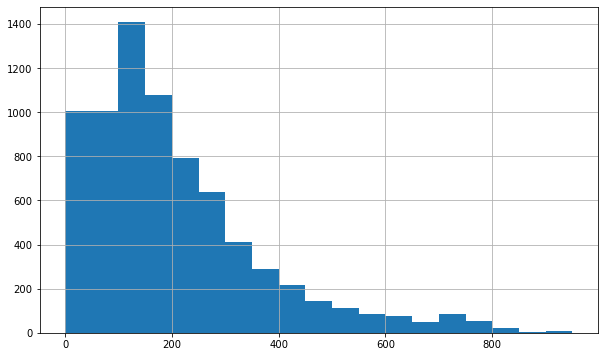

In [ ]:
df_review_data.num_tokens.hist(bins = range(0, 1000, 50), figsize = (10, 6))

In [ ]:
# number of tokens with fequency >= 5
sent_lengths = df_review_data.num_tokens.tolist()

for l in [2, 5, 10, 20, 30, 50, 100, 150, 200, 300, 400, 500, 1000]:
    temp = [s_len for s_len in sent_lengths if s_len > l]
    print(f"num of sent with tokens >={l}: ", len(temp))

num of sent with tokens >=2:  7500
num of sent with tokens >=5:  7500
num of sent with tokens >=10:  7433
num of sent with tokens >=20:  7124
num of sent with tokens >=30:  6858
num of sent with tokens >=50:  6481
num of sent with tokens >=100:  5479
num of sent with tokens >=150:  4074
num of sent with tokens >=200:  2998
num of sent with tokens >=300:  1560
num of sent with tokens >=400:  874
num of sent with tokens >=500:  524
num of sent with tokens >=1000:  17


In [ ]:
# average length per class
df_review_data.groupby("review_class").agg({'num_tokens': ['min', 'max', 'median', 'mean', 'std']})

num_tokens                                     
                    min   max median        mean         std
review_class                                                
average               8  1326  174.0  220.605500  180.525548
bad                   6  1173  158.5  201.744400  162.846444
good                  7  1212  162.0  205.896667  168.439615

In [ ]:
# average length per class
df_review_data.groupby("review_class_bin").agg({'num_tokens': ['min', 'max', 'median', 'mean', 'std']})

num_tokens                                     
                        min   max median        mean         std
review_class_bin                                                
bad                       6  1326    164  211.352651  176.822206
good                      7  1212    164  205.206864  163.604748

In [ ]:
# average length per genre
df_review_data.groupby("genre_primary_mapped").agg({'num_tokens': ['min', 'max', 'median', 'mean', 'std']})

num_tokens                                     
                            min   max median        mean         std
genre_primary_mapped                                                
action                        6  1194    152  192.916254  164.718652
adventure                     8  1283    188  233.311947  167.537433
animation                     9  1013    150  204.610169  166.549294
biography                    10   875    197  236.033058  164.679310
comedy                        8  1212    157  204.860666  169.868020
drama                         8  1326    172  222.545148  183.421608
horror                       13   767    205  237.026738  163.637596
thriller/crime                8  1179    159  200.181176  159.965029
western                       8  1046    190  241.500000  204.293759

## train/test split

In [ ]:
# split data into train/test
df_train, df_test = train_test_split(df_review_data, test_size=0.20, random_state=SEED)
df_train.shape, df_test.shape

((6000, 18), (1500, 18))

In [ ]:
x_train = df_train.review_processed.values
y_train = df_train.review_class_int.values

x_test = df_test.review_processed.values
y_test = df_test.review_class_int.values

len(x_train), len(y_train), len(x_test), len(y_test)

(6000, 6000, 1500, 1500)

In [ ]:
print(Counter(y_train))
print(Counter(y_test))

Counter({2: 2382, 0: 2016, 1: 1602})
Counter({2: 618, 0: 484, 1: 398})


## tokenize data

In [ ]:
# after analyzing above vocab stats, we set our vocab size to be 35k
VOCAB_SIZE = 35000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters='')

# we fit tokenizer on x_train data
tokenizer.fit_on_texts(x_train)

x_train_idx = tokenizer.texts_to_sequences(x_train)
x_train_tok = tokenizer.sequences_to_texts(x_train_idx)

x_test_idx = tokenizer.texts_to_sequences(x_test)
x_test_tok = tokenizer.sequences_to_texts(x_test_idx)

print(len(x_train_idx), len(x_train_tok))
print(len(x_test_idx), len(x_test_tok))

6000 6000
1500 1500


In [ ]:
# displays a random sent and ids
def display_sample(x_tok, x_idx, y, k=None):
    if not k:
        k = random.randint(0, len(x_tok)-1)
    print("k:", k, "label:", y[k])
    print("length of toks and idx:", len(x_tok[k].split()), len(x_idx[k]),  end="\n\n")
    print("sent tok:", x_tok[k].split(), end="\n\n")
    print("sent idx:", x_idx[k])

In [ ]:
display_sample(x_train_tok, x_train_idx, y_train)

k: 723 label: 0
length of toks and idx: 275 275

sent tok: ['super', 'boredom', 'deluxe', 'edition', 'so', 'much', 'have', 'heard', 'about', 'film', 'turned', 'out', 'to', 'biggest', 'dissapointment', 'of', 'last', 'year', 'having', 'vijay', 'sethupathi', 'fahadh', 'faasil', 'in', 'same', 'frame', 'big', 'thingwhich', 'never', 'happened', 'in', 'film', 'though', 'then', 'ramya', 'krishnan', 'samantha', 'have', 'ability', 'to', 'surprise', 'us', 'moreover', 'deals', 'with', 'subject', 'most', 'indians', 'ashamed', 'to', 'talk', 'some', 'taboos', 'some', 'stigmas', 'there', 'dozens', 'of', 'reasons', 'always', 'on', 'wishlistsuper', 'deluxe', 'consists', 'five', 'different', 'stories', 'each', 'of', 'in', 'some', 'way', 'related', 'to', 'religion', 'superstitions', 'sex', 'stories', '1a', 'man', 'dies', 'while', 'having', 'sex', 'with', 'vaembusamantha', 'husband', 'mugilfahadh', 'refuses', 'to', 'accept', 'after', 'knowing', 'but', 'before', 'have', 'bigger', 'task', 'to', 'dispose', 'd

In [ ]:
display_sample(x_train_tok, x_train_idx, y_train)

k: 1681 label: 2
length of toks and idx: 23 23

sent tok: ['enjoyable', 'worth', '<unk>', 'in', 'few', 'things', 'bad', 'make', 'up', 'feels', 'stretched', 'some', 'of', 'actorsit', 'feels', 'very', 'commercial', 'would', 'have', 'liked', 'more', 'if', 'subtle']

sent idx: [761, 269, 1, 4, 130, 133, 67, 62, 34, 442, 2979, 28, 2, 26059, 442, 30, 877, 45, 15, 369, 31, 33, 1002]


### pad data

In [ ]:
# we need to add <pad> token with index 0 to tokenizer.word_index 
tokenizer.word_index.update({'<pad>':0})
tokenizer.index_word.update({0:'<pad>'})

# since tokenizer.word_index has all words > we get only what's under VOCAB_SIZE
word2idx = {w:idx for w,idx in tokenizer.word_index.items() if idx < VOCAB_SIZE}
idx2word = {idx:w for w,idx in word2idx.items()}

# adjust VOCAB_SIZE
VOCAB_SIZE = len(word2idx)

print("len word2idx: ", len(word2idx))
print("len idx2word: ", len(idx2word))
print("vocab size: ", VOCAB_SIZE)
print("")

len word2idx:  35000
len idx2word:  35000
vocab size:  35000



In [ ]:
# check idx2word and word2idx mapping
list(zip(list(word2idx.items())[:10], list(idx2word.items())[:10]))

[(('<unk>', 1), (1, '<unk>')),
 (('of', 2), (2, 'of')),
 (('to', 3), (3, 'to')),
 (('in', 4), (4, 'in')),
 (('as', 5), (5, 'as')),
 (('with', 6), (6, 'with')),
 (('for', 7), (7, 'for')),
 (('film', 8), (8, 'film')),
 (('but', 9), (9, 'but')),
 (('movie', 10), (10, 'movie'))]

In [ ]:
# we set MAX_SEQ_LEN analyzing the sequence length: mean: 144 and median: 90
MAX_SEQ_LEN = 300

# pad sequences so that we get a N x MAX_SEQ_LEN matrix
x_train_idx_padded = pad_sequences(x_train_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)
x_test_idx_padded = pad_sequences(x_test_idx, maxlen=MAX_SEQ_LEN, padding='post', truncating='post', value=0)

print(x_train_idx_padded.shape, x_test_idx_padded.shape)

(6000, 300) (1500, 300)


In [ ]:
i = 10
print(x_train_idx_padded[i])
print(tokenizer.sequences_to_texts([x_train_idx_padded[i]]))

[  913     2    44  1781   192    12 18954   913     2    44  1781   192
    12 18954     9   102    72   155   601  1656   125    59    18   127
    38  1048     2  1581     2  1181   996    35    30   847     6 12050
 18955   164    65     2  2041  7744   452   375     2    92 16466     6
   107  7363    17     2  2530    77   171   824     9  2215  1476    49
    42    26    35   119     2   635   771     2   264  5080    79    51
  1952     6   271   379    43  3974    31 14618    26    35  3975   967
    43    67   390  3974   165  1657     6   318     9   386   106     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

## word embedding

In [ ]:
def load_embeddings(embed_path, type="glove"):
    print(f'loading word vectors from: {embed_path}')
    embed = {}
    
    with open(embed_path, "r", encoding="utf-8") as f:
        # skip first line
        if type == "ft":
            n, d = map(int, f.readline().split())

        # space-separated text file in the format: word [vector of floats]
        for line in f:
            line = line.strip().split(' ')
            embed[line[0]] = np.asarray(line[1:], dtype='float32')

    print(f"\tembed word count: {len(embed)}")
    print(f"\tembed dim: {len(embed[line[0]])}")
    return embed


def built_embed_matrix(embed, word2idx, VOCAB_SIZE, EMBED_DIM, type=""):
    print('\nprepare embedding matrix...')

    embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
    embed_cnt = 0
    unk_words = []

    if type == "w2v":
        for word, idx in word2idx.items():
            try:
                embedding_vector = embed.get_vector(word)
                embedding_matrix[idx] = embedding_vector
                embed_cnt += 1
            except KeyError as e:
                unk_words.append((word, idx))

    else:
        for word, idx in word2idx.items():
            embedding_vector = embed.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
                embed_cnt += 1
            else:
                unk_words.append((word, idx))
          
                
    print(f"\tembedding matrix shape: {embedding_matrix.shape}")
    print(f"\tword embedding found: {embed_cnt}")
    print(f"\tword embedding not found: {len(unk_words)}")

    return embedding_matrix, unk_words


In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-11-29 23:02:52--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-29 23:02:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 40s  

2021-11-29 23:05:33 (5.12 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# embedding_path = "C:/Codes/Embeddings/"
embedding_path = "/content/"

with open(embedding_path + "glove.6B.50d.txt", "r", encoding="utf-8") as f:
    for i,line in enumerate(f):
        line = line.strip().split(' ')
        print(line[0], np.asarray(line[1:], dtype='float32'))
        print("")
        
        if i == 5:
            break

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]

, [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938   0.13001  -0.063734 -0.39575  -0.48162
  0.23291   0.090201 -0.13324   0.078639 -0.41634  -0.15428   0.10068
  0.48891   0.31226  -0.1252   -0.037512 -1.5179    0.12612  -0.02442
 -0.042961 -0.28351   3.5416   -0.11956  -0.014533 -0.1499    0.21864
 -0.33412  -0.13872   0.31806   0

In [ ]:
EMBED_DIM = 50

glove_embed = load_embeddings(embedding_path + "glove.6B.50d.txt")
glove_embed_matrix, glove_unknown_words = built_embed_matrix(glove_embed, word2idx, VOCAB_SIZE, EMBED_DIM)

loading word vectors from: /content/glove.6B.50d.txt
	embed word count: 400000
	embed dim: 50

prepare embedding matrix...
	embedding matrix shape: (35000, 50)
	word embedding found: 28608
	word embedding not found: 6392


In [ ]:
glove_embed_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## model

In [ ]:
def build_lstm_model(embedding_matrix, EMBED_DIM, NUM_LABELS, verbose=False):

    input_ = Input(shape=(MAX_SEQ_LEN,), name="input")

    embed_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length = MAX_SEQ_LEN,
                      weights=[embedding_matrix], trainable=False, mask_zero=True)(input_)

    lstm_layer = Bidirectional(LSTM(units=64, dropout=.1, recurrent_dropout=0.1,
                               kernel_regularizer = regularizers.l2(0.01)), name="lstm")(embed_layer)
    
    dense_layer = Dense(64, activation='relu')(lstm_layer)
    out = Dense(NUM_LABELS, activation='softmax', name='review_output')(dense_layer)
     
    model = Model(input_, out)
    
    if verbose:
        print(model.summary())

    return model


In [ ]:
model_folder = 'saved_models/'
checkpoint_callback = ModelCheckpoint(model_folder + 'lstm_{epoch:02d}_{val_accuracy:.4f}.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
earlystop_callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
model = build_lstm_model(glove_embed_matrix, EMBED_DIM, NUM_LABELS=3, verbose=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 50)           1750000   
                                                                 
 lstm (Bidirectional)        (None, 128)               58880     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 review_output (Dense)       (None, 3)                 195       
                                                                 
Total params: 1,817,331
Trainable params: 67,331
Non-trainable params: 1,750,000
_________________________________________________________________
None


In [ ]:
epochs = 10
batch_size = 256

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy

model.compile(optimizer = optimizer,
                  loss = loss, 
                  metrics= ["accuracy"]) 

history = model.fit(x_train_idx_padded, y_train,
                     batch_size = batch_size,
                     epochs = epochs,
                     # class_weight = class_weights,
                     callbacks = [checkpoint_callback, earlystop_callback],
                     validation_data = (x_test_idx_padded, y_test)
                    )

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 2.3966 - accuracy: 0.4617
Epoch 00001: val_accuracy improved from -inf to 0.49133, saving model to saved_models\lstm_01_0.4913.h5
24/24 [==============================] - 137s 5s/step - loss: 2.3966 - accuracy: 0.4617 - val_loss: 2.0390 - val_accuracy: 0.4913
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.7780 - accuracy: 0.5328
Epoch 00002: val_accuracy improved from 0.49133 to 0.56067, saving model to saved_models\lstm_02_0.5607.h5
24/24 [==============================] - 134s 6s/step - loss: 1.7780 - accuracy: 0.5328 - val_loss: 1.5363 - val_accuracy: 0.5607
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.5658
Epoch 00003: val_accuracy improved from 0.56067 to 0.58467, saving model to saved_models\lstm_03_0.5847.h5
24/24 [==============================] - 138s 6s/step - loss: 1.4087 - accuracy: 0.5658 - val_loss: 1.2768 - val_accuracy: 0.5847
Epoch 4/10

KeyboardInterrupt: 

### prediction

In [ ]:
model = load_model(model_folder + "lstm_04_0.5980.h5")

In [ ]:
y_pred = model.predict(x_test_idx_padded)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(1500, 3)
(1500,)


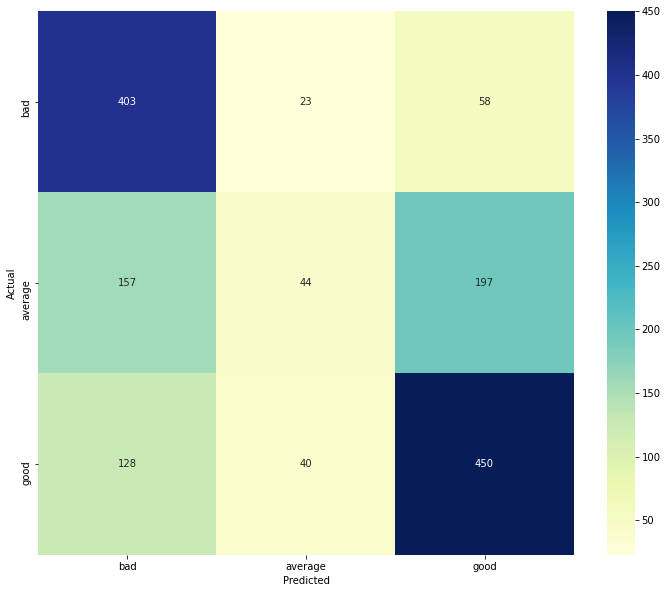

In [ ]:
# confusion matrix
class_names = ["bad", "average", "good"]
cmat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## model binary

In [ ]:
y_train_bin = df_train.review_class_bin_int.values
y_test_bin = df_test.review_class_bin_int.values

print(Counter(y_train_bin))
print(Counter(y_test_bin))
print(len(y_train_bin), len(y_test_bin))

Counter({1: 3391, 0: 2609})
Counter({1: 853, 0: 647})
6000 1500


In [ ]:
model_folder = 'saved_models/'
checkpoint_callback = ModelCheckpoint(model_folder + 'lstm_binary_{epoch:02d}_{val_accuracy:.4f}.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
earlystop_callback = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
model_bin = build_lstm_model(glove_embed_matrix, EMBED_DIM, NUM_LABELS=2, verbose=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 50)           1750000   
                                                                 
 lstm (Bidirectional)        (None, 128)               58880     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 review_output (Dense)       (None, 2)                 130       
                                                                 
Total params: 1,817,266
Trainable params: 67,266
Non-trainable params: 1,750,000
_________________________________________________________________
None


In [ ]:
epochs = 3
batch_size = 256

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy

model_bin.compile(optimizer = optimizer,
                  loss = loss, 
                  metrics= ["accuracy"]) 

history = model_bin.fit(x_train_idx_padded, y_train_bin,
                     batch_size = batch_size,
                     epochs = epochs,
                     # class_weight = class_weights,
                     callbacks = [checkpoint_callback, earlystop_callback],
                     validation_data = (x_test_idx_padded, y_test_bin)
                    )

Epoch 1/3
24/24 [==============================] - ETA: 0s - loss: 1.9811 - accuracy: 0.6347
Epoch 00001: val_accuracy improved from -inf to 0.69200, saving model to saved_models\lstm_binary_01_0.6920.h5
24/24 [==============================] - 146s 6s/step - loss: 1.9811 - accuracy: 0.6347 - val_loss: 1.5922 - val_accuracy: 0.6920
Epoch 2/3
24/24 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.7140
Epoch 00002: val_accuracy improved from 0.69200 to 0.73800, saving model to saved_models\lstm_binary_02_0.7380.h5
24/24 [==============================] - 135s 6s/step - loss: 1.3637 - accuracy: 0.7140 - val_loss: 1.1367 - val_accuracy: 0.7380
Epoch 3/3
24/24 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.7308
Epoch 00003: val_accuracy did not improve from 0.73800
24/24 [==============================] - 138s 6s/step - loss: 1.0227 - accuracy: 0.7308 - val_loss: 0.9599 - val_accuracy: 0.6933


### prediction binary

In [ ]:
y_pred = model_bin.predict(x_test_idx_padded)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred.shape)

(1500, 2)
(1500,)


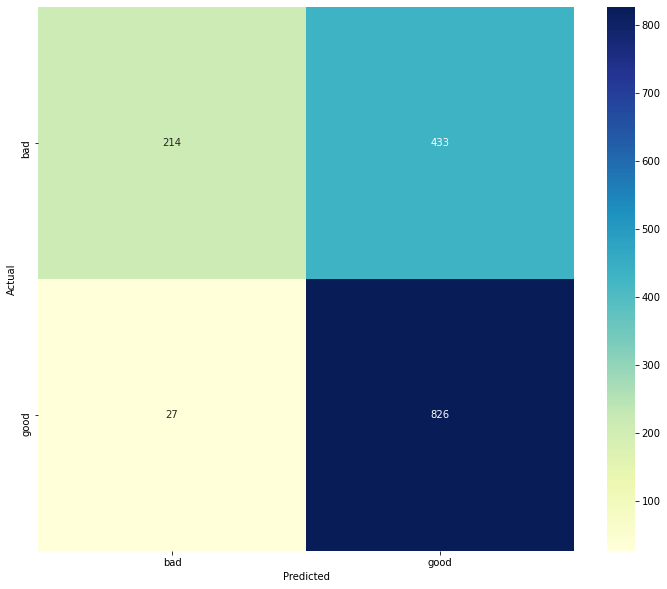

In [ ]:
# confusion matrix
class_names = ["bad", "good"]
cmat = confusion_matrix(y_test_bin, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_test_bin, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.33      0.48       647
           1       0.66      0.97      0.78       853

    accuracy                           0.69      1500
   macro avg       0.77      0.65      0.63      1500
weighted avg       0.76      0.69      0.65      1500



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred)
auc_scores = auc(fpr, tpr)

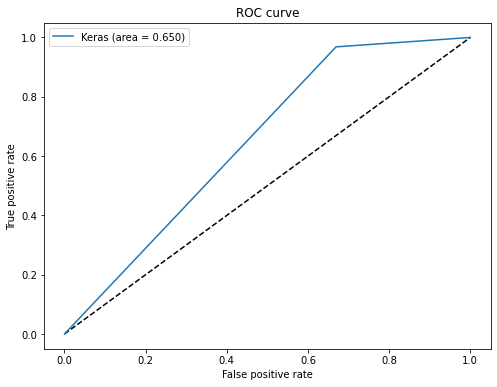

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_scores))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

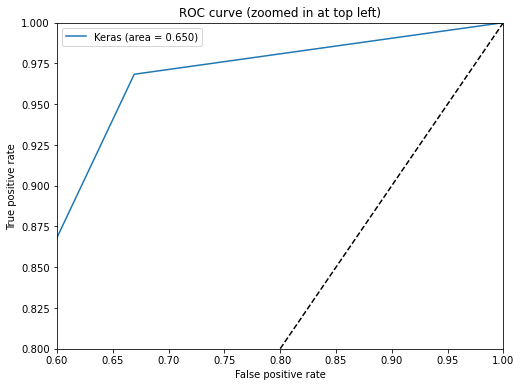

In [ ]:
# Zoom in view of the upper left corner.
plt.figure(figsize = (8, 6))
plt.xlim(0.6, 1)
plt.ylim(0.8, 1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_scores))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_pred)

No handles with labels found to put in legend.


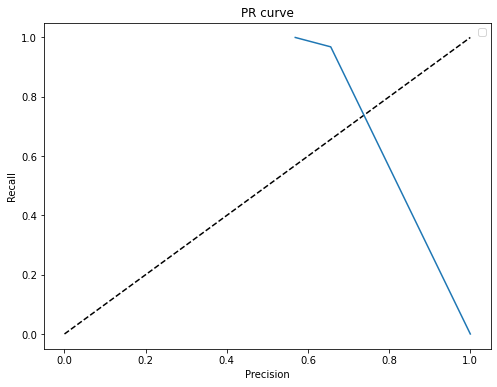

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR curve')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model_bin.predict(x_test_idx_padded)
print(y_pred.shape)

(1500, 2)


In [ ]:
y_pred[0]

array([0.16757266, 0.8324273 ], dtype=float32)

In [ ]:
y_pred_final = np.argmax(y_pred, axis=1)
print(classification_report(y_test_bin, y_pred_final))

              precision    recall  f1-score   support

           0       0.89      0.33      0.48       647
           1       0.66      0.97      0.78       853

    accuracy                           0.69      1500
   macro avg       0.77      0.65      0.63      1500
weighted avg       0.76      0.69      0.65      1500



In [ ]:
thresholds = [0.4, 0.5, .6, 0.7, 0.8, 0.9]

for thres in thresholds:
    print("\n", "-"*50)
    print(f"{thres = }")
    y_pred_final = [1 if max(pred)>=thres else 0 for pred in y_pred]
    print(classification_report(y_test_bin, y_pred_final))
    


 --------------------------------------------------
thres = 0.4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       647
           1       0.57      1.00      0.73       853

    accuracy                           0.57      1500
   macro avg       0.28      0.50      0.36      1500
weighted avg       0.32      0.57      0.41      1500


 --------------------------------------------------
thres = 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       647
           1       0.57      1.00      0.73       853

    accuracy                           0.57      1500
   macro avg       0.28      0.50      0.36      1500
weighted avg       0.32      0.57      0.41      1500


 --------------------------------------------------
thres = 0.6
              precision    recall  f1-score   support

           0       0.69      0.25      0.37       647
           1       0.62      0.92      0.7

C:\Users\Aartipol9\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aartipol9\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aartipol9\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aartipol9\miniconda3\lib\site-p

## model bias free

In [ ]:
def build_lstm_model_bias_free(embedding_matrix, EMBED_DIM, NUM_LABELS_REVIEW, NUM_LABELS_GENRE, verbose=False):

    input_ = Input(shape=(MAX_SEQ_LEN,), name="input")
    
    embed_rating = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length = MAX_SEQ_LEN,
                           weights=[embedding_matrix], trainable=False, mask_zero=True, name='embed_rating')(input_)
    
    embed_genre = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length = MAX_SEQ_LEN,
                           weights=[embedding_matrix], trainable=False, mask_zero=True, name='embed_genre')(input_)
    
    lstm_rating = Bidirectional(LSTM(units=64, dropout=.1, recurrent_dropout=0.1,
                               kernel_regularizer = regularizers.l2(0.01)), name="lstm_rating")(embed_rating)
    
    lstm_genre = Bidirectional(LSTM(units=64, dropout=.1, recurrent_dropout=0.1,
                               kernel_regularizer = regularizers.l2(0.01)), name="lstm_genre")(embed_genre)
    
    concat_layer = concatenate([lstm_rating, lstm_genre])
    
    dense_layer = Dense(128, activation='relu')(concat_layer)
    dense_layer = Dense(64, activation='relu')(dense_layer)
    
    out_rating = Dense(NUM_LABELS_REVIEW, activation='softmax', name='output_rating')(dense_layer)
    out_genre = Dense(NUM_LABELS_GENRE, activation='softmax', name='output_genre')(dense_layer)
     
    model = Model(input_, [out_rating, out_genre])
    
    if verbose:
        print(model.summary())
        
    return model


In [ ]:
model_bias_free = build_lstm_model_bias_free(glove_embed_matrix, EMBED_DIM, NUM_LABELS_REVIEW=2, NUM_LABELS_GENRE=9, verbose=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embed_rating (Embedding)       (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 embed_genre (Embedding)        (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 lstm_rating (Bidirectional)    (None, 128)          58880       ['embed_rating[0][0]']           
                                                                                              

In [ ]:
y_train_bin = df_train.review_class_bin_int.values
y_test_bin = df_test.review_class_bin_int.values

y_train_genre = df_train.genre_label.values
y_test_genre = df_test.genre_label.values


print(Counter(y_train_bin))
print(Counter(y_test_bin))
print(len(y_train_bin), len(y_test_bin))
print("")

print(Counter(y_train_genre))
print(Counter(y_test_genre))
print(len(y_train_genre), len(y_test_genre))


Counter({1: 3377, 0: 2623})
Counter({1: 862, 0: 638})
6000 1500

Counter({0: 1789, 1: 1297, 2: 1182, 3: 685, 4: 369, 5: 269, 6: 234, 7: 153, 8: 22})
Counter({0: 432, 1: 325, 2: 302, 3: 165, 5: 94, 4: 83, 6: 61, 7: 34, 8: 4})
6000 1500


### alpha = -0.5

In [ ]:
#Since our inputs and outputs are named (we passed them a "name" argument)

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy
alpha = -0.5

model_bias_free .compile(optimizer=optimizer,
                         loss={'output_rating': loss, 'output_genre': loss},
                         loss_weights={'output_rating': 1., 'output_genre': alpha},
                         metrics = ['accuracy'])

In [ ]:
model_folder = 'saved_models/'
checkpoint_callback = ModelCheckpoint(model_folder + 'lstm_bias_{epoch:02d}_{val_output_rating_accuracy:.4f}.h5', save_best_only=True, 
                                      monitor='val_output_rating_accuracy', verbose=1)
earlystop_callback = EarlyStopping(monitor='val_output_rating_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
epochs = 5
batch_size = 512

history_bias_free = model_bias_free.fit(x_train_idx_padded, 
                                        y={"output_rating": y_train_bin, "output_genre": y_train_genre},
                                        batch_size = batch_size,
                                        epochs = epochs,
                                        callbacks = [checkpoint_callback, earlystop_callback],
                                        validation_data=(x_test_idx_padded,
                                                         {"output_rating": y_test_bin, "output_genre": y_test_genre}),
                                       )

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: -8.0969 - output_rating_loss: 0.6990 - output_genre_loss: 22.5246 - output_rating_accuracy: 0.5673 - output_genre_accuracy: 0.0615
Epoch 00001: val_output_rating_accuracy improved from -inf to 0.58000, saving model to saved_models/lstm_bias_01_0.5800.h5
12/12 [==============================] - 125s 9s/step - loss: -8.0969 - output_rating_loss: 0.6990 - output_genre_loss: 22.5246 - output_rating_accuracy: 0.5673 - output_genre_accuracy: 0.0615 - val_loss: -22.3002 - val_output_rating_loss: 0.6627 - val_output_genre_loss: 50.4618 - val_output_rating_accuracy: 0.5800 - val_output_genre_accuracy: 0.0553
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: -43.7051 - output_rating_loss: 0.6729 - output_genre_loss: 93.0140 - output_rating_accuracy: 0.5802 - output_genre_accuracy: 0.0615
Epoch 00002: val_output_rating_accuracy did not improve from 0.58000
12/12 [==============================] - 108s 9s/step - lo

#### plots

In [ ]:
pd.DataFrame(history_bias_free.history)

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.407258,0.674142,2.346550,0.585833,0.095000,2.913821,0.628570,2.809865,0.629333,0.042667
1,2.413059,0.611402,4.834399,0.667333,0.040500,1.544805,0.598194,10.233562,0.670000,0.062000
2,-0.001975,0.606136,23.728245,0.672833,0.044833,-2.909179,0.618467,50.652538,0.680000,0.062667
3,-7.897210,0.660616,99.476524,0.618833,0.044833,-15.654451,0.702771,175.835495,0.435333,0.062667
4,-25.709917,0.778464,276.077698,0.525833,0.044833,-39.182343,0.687709,408.692383,0.576000,0.062667


In [39]:
df_log_05 = pd.read_csv("bias_free_logs_alpha=-0.5.csv")
df_log_05

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.407258,0.674142,2.346550,0.585833,0.095000,2.913821,0.628570,2.809865,0.629333,0.042667
1,2.413059,0.611402,4.834399,0.667333,0.040500,1.544805,0.598194,10.233562,0.670000,0.062000
2,-0.001975,0.606136,23.728245,0.672833,0.044833,-2.909179,0.618467,50.652538,0.680000,0.062667
3,-7.897210,0.660616,99.476524,0.618833,0.044833,-15.654451,0.702771,175.835495,0.435333,0.062667
4,-25.709917,0.778464,276.077698,0.525833,0.044833,-39.182343,0.687709,408.692383,0.576000,0.062667


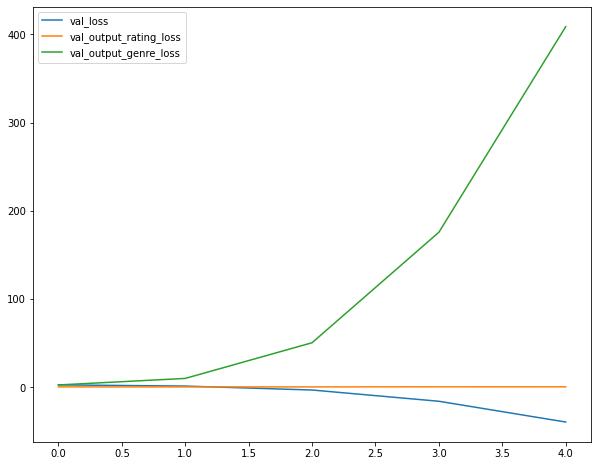

In [43]:
df_log_05[["val_loss", "val_output_rating_loss", "val_output_genre_loss"]].plot(figsize=(10, 8))

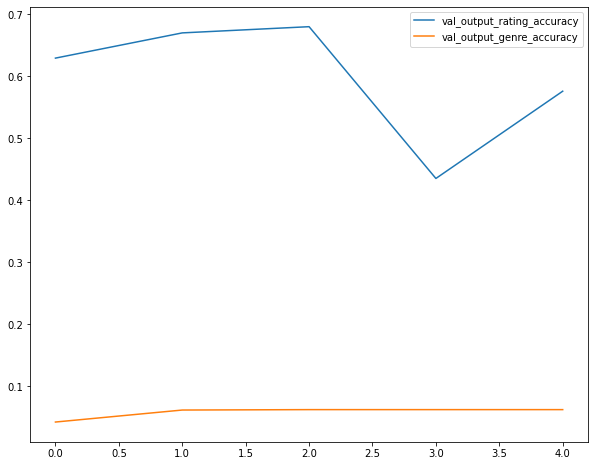

In [44]:
df_log_05[["val_output_rating_accuracy", "val_output_genre_accuracy"]].plot(figsize=(10, 8))

#### prediction

In [ ]:
y_pred = model_bias_free.predict(x_test_idx_padded)
print(y_pred[0].shape, y_pred[1].shape)

(1500, 2) (1500, 9)


In [ ]:
y_pred_rating = np.argmax(y_pred[0], axis=1)
y_pred_genre = np.argmax(y_pred[1], axis=1)
print(y_pred_rating.shape, y_pred_genre.shape)

(1500,) (1500,)


In [ ]:
# confusion matrix
class_names = ["bad", "good"]
cmat = confusion_matrix(y_test_bin, y_pred_rating)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print(classification_report(y_test_bin, y_pred_rating))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       638
           1       0.00      0.00      0.00       862

    accuracy                           0.43      1500
   macro avg       0.21      0.50      0.30      1500
weighted avg       0.18      0.43      0.25      1500



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_pred[0]

array([[0.8146192 , 0.18538083],
       [0.81384254, 0.18615748],
       [0.81439555, 0.18560444],
       ...,
       [0.81434596, 0.18565404],
       [0.81436676, 0.18563329],
       [0.81423175, 0.18576828]], dtype=float32)

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for thres in thresholds:
    print("\n", "-"*50)
    print(f"thres: {thres}")
    y_pred_rating = [1 if pred[1]>=thres else 0 for pred in y_pred[0]]
    print(classification_report(y_test_bin, y_pred_rating))
    


 --------------------------------------------------
thres: 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       638
           1       0.57      1.00      0.73       862

    accuracy                           0.57      1500
   macro avg       0.29      0.50      0.36      1500
weighted avg       0.33      0.57      0.42      1500


 --------------------------------------------------
thres: 0.2
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       638
           1       1.00      0.00      0.00       862

    accuracy                           0.43      1500
   macro avg       0.71      0.50      0.30      1500
weighted avg       0.76      0.43      0.26      1500


 --------------------------------------------------
thres: 0.3
              precision    recall  f1-score   support

           0       0.43      1.00      0.60       638
           1       0.00      0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

### alpha = -0.10

In [ ]:
model_bias_free = build_lstm_model_bias_free(glove_embed_matrix, EMBED_DIM, NUM_LABELS_REVIEW=2, NUM_LABELS_GENRE=9, verbose=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embed_rating (Embedding)       (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 embed_genre (Embedding)        (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 lstm_rating (Bidirectional)    (None, 128)          58880       ['embed_rating[0][0]']           
                                                                                            

In [ ]:
#Since our inputs and outputs are named (we passed them a "name" argument)

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy
alpha = -0.10

model_bias_free .compile(optimizer=optimizer,
                         loss={'output_rating': loss, 'output_genre': loss},
                         loss_weights={'output_rating': 1., 'output_genre': alpha},
                         metrics = ['accuracy'])

In [ ]:
epochs = 5
batch_size = 512

history_bias_free = model_bias_free.fit(x_train_idx_padded, 
                                        y={"output_rating": y_train_bin, "output_genre": y_train_genre},
                                        batch_size = batch_size,
                                        epochs = epochs,
                                        callbacks = [checkpoint_callback, earlystop_callback],
                                        validation_data=(x_test_idx_padded,
                                                         {"output_rating": y_test_bin, "output_genre": y_test_genre}),
                                       )

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 3.4073 - output_rating_loss: 0.6741 - output_genre_loss: 2.3465 - output_rating_accuracy: 0.5858 - output_genre_accuracy: 0.0950
Epoch 00001: val_output_rating_accuracy improved from -inf to 0.62933, saving model to saved_models/lstm_bias_01_0.6293.h5
12/12 [==============================] - 124s 9s/step - loss: 3.4073 - output_rating_loss: 0.6741 - output_genre_loss: 2.3465 - output_rating_accuracy: 0.5858 - output_genre_accuracy: 0.0950 - val_loss: 2.9138 - val_output_rating_loss: 0.6286 - val_output_genre_loss: 2.8099 - val_output_rating_accuracy: 0.6293 - val_output_genre_accuracy: 0.0427
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 2.4131 - output_rating_loss: 0.6114 - output_genre_loss: 4.8344 - output_rating_accuracy: 0.6673 - output_genre_accuracy: 0.0405
Epoch 00002: val_output_rating_accuracy improved from 0.62933 to 0.67000, saving model to saved_models/lstm_bias_02_0.6700.h5
12/12 [====

In [ ]:
pd.DataFrame(history_bias_free.history)

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.407258,0.674142,2.346550,0.585833,0.095000,2.913821,0.628570,2.809865,0.629333,0.042667
1,2.413059,0.611402,4.834399,0.667333,0.040500,1.544805,0.598194,10.233562,0.670000,0.062000
2,-0.001975,0.606136,23.728245,0.672833,0.044833,-2.909179,0.618467,50.652538,0.680000,0.062667
3,-7.897210,0.660616,99.476524,0.618833,0.044833,-15.654451,0.702771,175.835495,0.435333,0.062667
4,-25.709917,0.778464,276.077698,0.525833,0.044833,-39.182343,0.687709,408.692383,0.576000,0.062667


#### plots

In [45]:
df_log_01 = pd.read_csv("bias_free_logs_alpha=-0.1.csv")
df_log_01

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.407258,0.674142,2.346550,0.585833,0.095000,2.913821,0.628570,2.809865,0.629333,0.042667
1,2.413059,0.611402,4.834399,0.667333,0.040500,1.544805,0.598194,10.233562,0.670000,0.062000
2,-0.001975,0.606136,23.728245,0.672833,0.044833,-2.909179,0.618467,50.652538,0.680000,0.062667
3,-7.897210,0.660616,99.476524,0.618833,0.044833,-15.654451,0.702771,175.835495,0.435333,0.062667
4,-25.709917,0.778464,276.077698,0.525833,0.044833,-39.182343,0.687709,408.692383,0.576000,0.062667


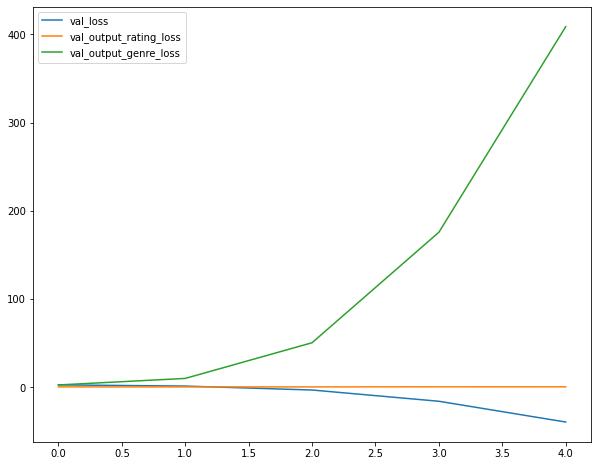

In [46]:
df_log_01[["val_loss", "val_output_rating_loss", "val_output_genre_loss"]].plot(figsize=(10, 8))

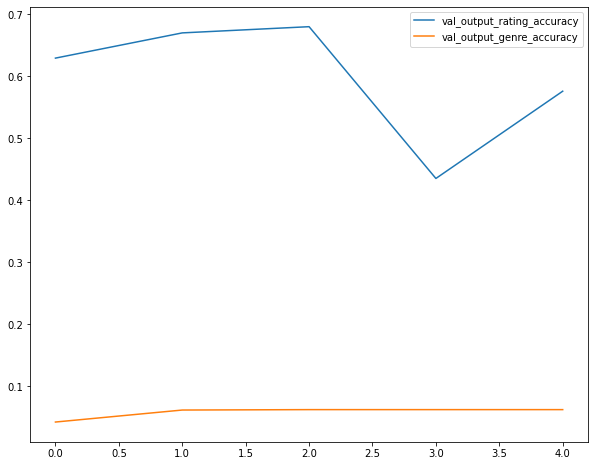

In [ ]:
df_log_01[["val_output_rating_accuracy", "val_output_genre_accuracy"]].plot(figsize=(10, 8))

#### prediction

In [ ]:
y_pred = model_bias_free.predict(x_test_idx_padded)
print(y_pred[0].shape, y_pred[1].shape)

(1500, 2) (1500, 9)


In [ ]:
y_pred_rating = np.argmax(y_pred[0], axis=1)
y_pred_genre = np.argmax(y_pred[1], axis=1)
print(y_pred_rating.shape, y_pred_genre.shape)

(1500,) (1500,)


In [ ]:
y_pred[0][:10]

array([[0.3798478 , 0.62015224],
       [0.34471396, 0.6552861 ],
       [0.35604817, 0.64395183],
       [0.3601066 , 0.63989335],
       [0.36524707, 0.6347529 ],
       [0.34094876, 0.6590512 ],
       [0.35501677, 0.64498323],
       [0.3527407 , 0.6472593 ],
       [0.33146033, 0.6685397 ],
       [0.3549945 , 0.6450055 ]], dtype=float32)

In [ ]:
thresholds = list(np.arange(.60, .70, .01))
print(thresholds)

for thres in thresholds:
    print("\n", "-"*50)
    print(f"thres: {thres}")
    y_pred_rating = [1 if pred[1]>=thres else 0 for pred in y_pred[0]]
    print(classification_report(y_test_bin, y_pred_rating))
    

[0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001]

 --------------------------------------------------
thres: 0.6
              precision    recall  f1-score   support

           0       0.75      0.01      0.03       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.66      0.51      0.38      1500
weighted avg       0.65      0.58      0.43      1500


 --------------------------------------------------
thres: 0.61
              precision    recall  f1-score   support

           0       0.73      0.02      0.03       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.66      0.51      0.38      1500
weighted avg       0.64      0.58      0.43      1500


 --------------------------------------------------
thres: 0.62
              precision    recall  f1-score   support

           0       0.60

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


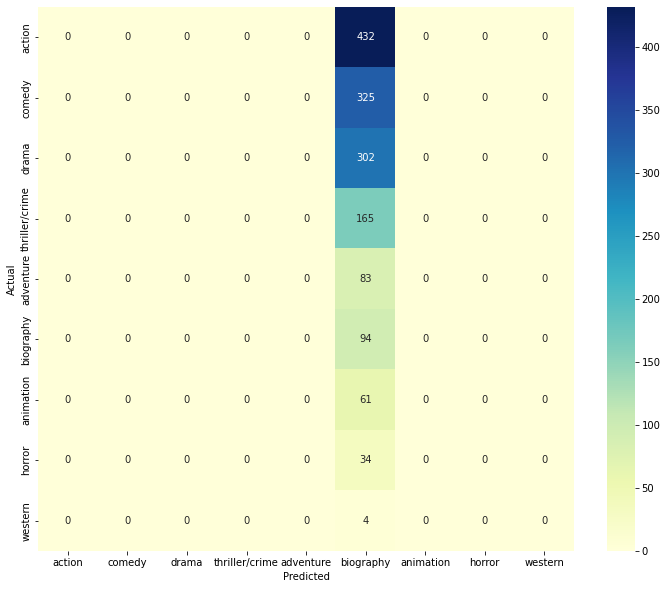

In [ ]:
# confusion matrix
class_names = list(genre2id.keys())
cmat = confusion_matrix(y_test_genre, y_pred_genre)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
!cp /content/saved_models/*  /content/drive/MyDrive/DAI_Project/saved_models/

### alpha = -0.05

In [ ]:
model_bias_free = build_lstm_model_bias_free(glove_embed_matrix, EMBED_DIM, NUM_LABELS_REVIEW=2, NUM_LABELS_GENRE=9, verbose=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embed_rating (Embedding)       (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 embed_genre (Embedding)        (None, 300, 50)      1750000     ['input[0][0]']                  
                                                                                                  
 lstm_rating (Bidirectional)    (None, 128)          58880       ['embed_rating[0][0]']           
                                                                                            

In [ ]:
#Since our inputs and outputs are named (we passed them a "name" argument)

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy
alpha = -0.10

model_bias_free .compile(optimizer=optimizer,
                         loss={'output_rating': loss, 'output_genre': loss},
                         loss_weights={'output_rating': 1., 'output_genre': alpha},
                         metrics = ['accuracy'])

In [ ]:
epochs = 5
batch_size = 512

history_bias_free = model_bias_free.fit(x_train_idx_padded, 
                                        y={"output_rating": y_train_bin, "output_genre": y_train_genre},
                                        batch_size = batch_size,
                                        epochs = epochs,
                                        callbacks = [checkpoint_callback, earlystop_callback],
                                        validation_data=(x_test_idx_padded,
                                                         {"output_rating": y_test_bin, "output_genre": y_test_genre}),
                                       )

Epoch 1/5
12/12 [==============================] - ETA: 0s - loss: 3.4073 - output_rating_loss: 0.6741 - output_genre_loss: 2.3465 - output_rating_accuracy: 0.5858 - output_genre_accuracy: 0.0950
Epoch 00001: val_output_rating_accuracy improved from -inf to 0.62933, saving model to saved_models/lstm_bias_01_0.6293.h5
12/12 [==============================] - 124s 9s/step - loss: 3.4073 - output_rating_loss: 0.6741 - output_genre_loss: 2.3465 - output_rating_accuracy: 0.5858 - output_genre_accuracy: 0.0950 - val_loss: 2.9138 - val_output_rating_loss: 0.6286 - val_output_genre_loss: 2.8099 - val_output_rating_accuracy: 0.6293 - val_output_genre_accuracy: 0.0427
Epoch 2/5
12/12 [==============================] - ETA: 0s - loss: 2.4131 - output_rating_loss: 0.6114 - output_genre_loss: 4.8344 - output_rating_accuracy: 0.6673 - output_genre_accuracy: 0.0405
Epoch 00002: val_output_rating_accuracy improved from 0.62933 to 0.67000, saving model to saved_models/lstm_bias_02_0.6700.h5
12/12 [====

In [ ]:
pd.DataFrame(history_bias_free.history)

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.407258,0.674142,2.346550,0.585833,0.095000,2.913821,0.628570,2.809865,0.629333,0.042667
1,2.413059,0.611402,4.834399,0.667333,0.040500,1.544805,0.598194,10.233562,0.670000,0.062000
2,-0.001975,0.606136,23.728245,0.672833,0.044833,-2.909179,0.618467,50.652538,0.680000,0.062667
3,-7.897210,0.660616,99.476524,0.618833,0.044833,-15.654451,0.702771,175.835495,0.435333,0.062667
4,-25.709917,0.778464,276.077698,0.525833,0.044833,-39.182343,0.687709,408.692383,0.576000,0.062667


#### plots

In [ ]:
df_log_005 = pd.read_csv("bias_free_logs_alpha=-0.05.csv")
df_log_005

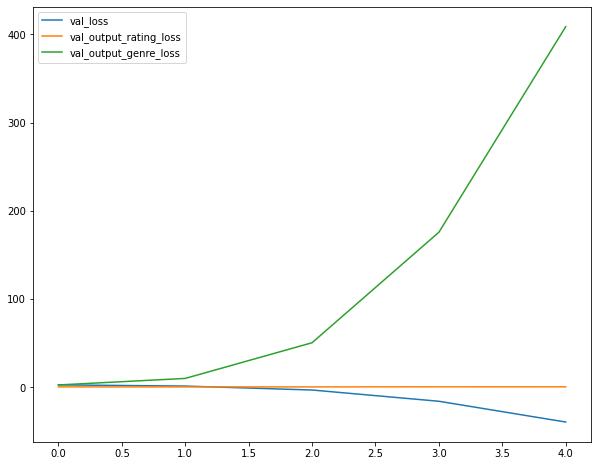

In [ ]:
df_log_005[["val_loss", "val_output_rating_loss", "val_output_genre_loss"]].plot(figsize=(10, 8))

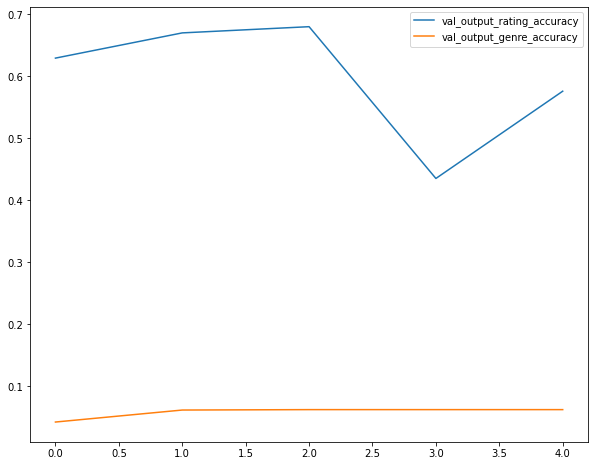

In [ ]:
df_log_005[["val_output_rating_accuracy", "val_output_genre_accuracy"]].plot(figsize=(10, 8))

#### prediction

In [ ]:
y_pred = model_bias_free.predict(x_test_idx_padded)
print(y_pred[0].shape, y_pred[1].shape)

(1500, 2) (1500, 9)


In [ ]:
y_pred_rating = np.argmax(y_pred[0], axis=1)
y_pred_genre = np.argmax(y_pred[1], axis=1)
print(y_pred_rating.shape, y_pred_genre.shape)

(1500,) (1500,)


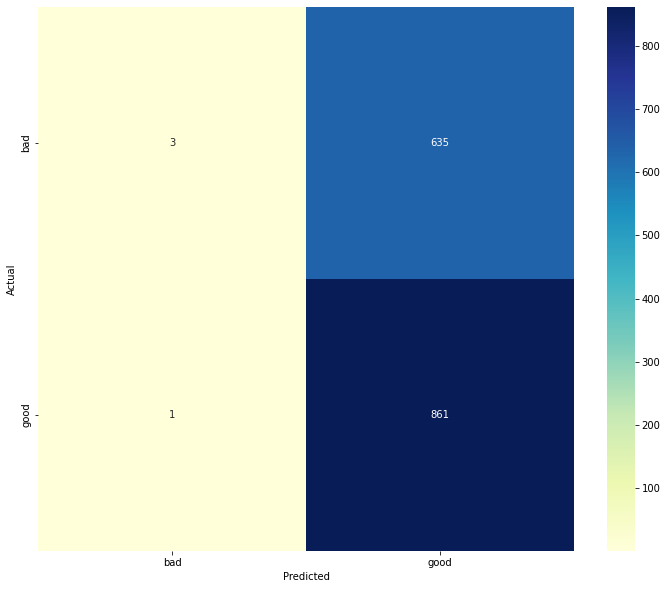

In [ ]:
# confusion matrix
class_names = ["bad", "good"]
cmat = confusion_matrix(y_test_bin, y_pred_rating)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_pred[0][:10]

array([[0.3798478 , 0.62015224],
       [0.34471396, 0.6552861 ],
       [0.35604817, 0.64395183],
       [0.3601066 , 0.63989335],
       [0.36524707, 0.6347529 ],
       [0.34094876, 0.6590512 ],
       [0.35501677, 0.64498323],
       [0.3527407 , 0.6472593 ],
       [0.33146033, 0.6685397 ],
       [0.3549945 , 0.6450055 ]], dtype=float32)

In [ ]:
thresholds = list(np.arange(.60, .70, .01))
print(thresholds)

for thres in thresholds:
    print("\n", "-"*50)
    print(f"thres: {thres}")
    y_pred_rating = [1 if pred[1]>=thres else 0 for pred in y_pred[0]]
    print(classification_report(y_test_bin, y_pred_rating))
    

[0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001]

 --------------------------------------------------
thres: 0.6
              precision    recall  f1-score   support

           0       0.75      0.01      0.03       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.66      0.51      0.38      1500
weighted avg       0.65      0.58      0.43      1500


 --------------------------------------------------
thres: 0.61
              precision    recall  f1-score   support

           0       0.73      0.02      0.03       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.66      0.51      0.38      1500
weighted avg       0.64      0.58      0.43      1500


 --------------------------------------------------
thres: 0.62
              precision    recall  f1-score   support

           0       0.60

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


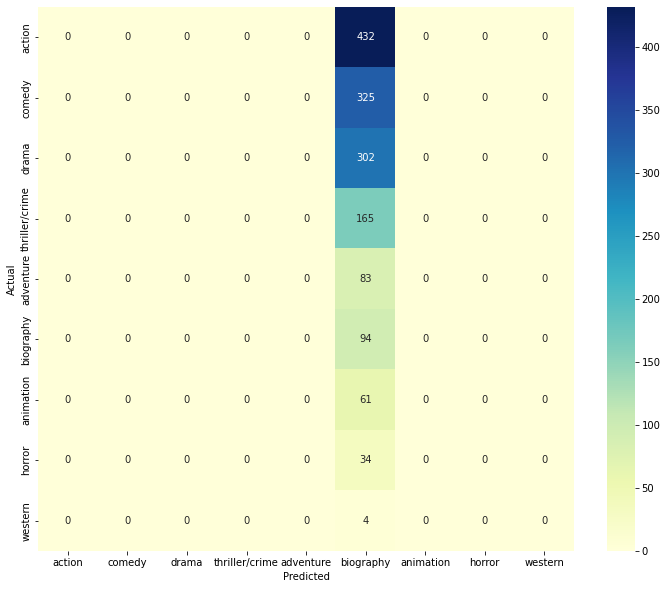

In [ ]:
# confusion matrix
class_names = list(genre2id.keys())
cmat = confusion_matrix(y_test_genre, y_pred_genre)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
!cp /content/saved_models/*  /content/drive/MyDrive/DAI_Project/saved_models/

### weighted version

In [ ]:
weight_rating = {i:wt for i,wt in enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_bin), y=y_train_bin))}
weight_genre = {i:wt for i,wt in enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_genre), y=y_train_genre))}

print(Counter(y_train_bin))
print(weight_rating)
print("")

print(Counter(y_train_genre))
print(weight_genre)

Counter({1: 3377, 0: 2623})
{0: 1.1437285550895921, 1: 0.8883624518803672}

Counter({0: 1789, 1: 1297, 2: 1182, 3: 685, 4: 369, 5: 269, 6: 234, 7: 153, 8: 22})
{0: 0.3726476616359232, 1: 0.5140066820868672, 2: 0.5640157924421884, 3: 0.9732360097323601, 4: 1.8066847335140017, 5: 2.4783147459727384, 6: 2.849002849002849, 7: 4.357298474945534, 8: 30.303030303030305}


In [ ]:
model_bias_free_wt = build_lstm_model_bias_free(glove_embed_matrix, EMBED_DIM, NUM_LABELS_REVIEW=2, NUM_LABELS_GENRE=9, verbose=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 300)]        0                                            
__________________________________________________________________________________________________
embed_rating (Embedding)        (None, 300, 50)      1750000     input[0][0]                      
__________________________________________________________________________________________________
embed_genre (Embedding)         (None, 300, 50)      1750000     input[0][0]                      
__________________________________________________________________________________________________
lstm_rating (Bidirectional)     (None, 128)          58880       embed_rating[0][0]               
____________________________________________________________________________________________

In [ ]:
#Since our inputs and outputs are named (we passed them a "name" argument)

# optimizer = SGD(learning_rate=0.01, momentum=0.9)
optimizer = Adam()
loss = sparse_categorical_crossentropy
alpha = -0.10

model_bias_free_wt .compile(optimizer=optimizer,
                         loss={'output_rating': loss, 'output_genre': loss},
                         loss_weights={'output_rating': 1., 'output_genre': alpha},
                         metrics = ['accuracy'])

In [ ]:
model_folder = 'saved_models/'
checkpoint_callback = ModelCheckpoint(model_folder + 'lstm_bias_wt_{epoch:02d}_{val_output_rating_accuracy:.4f}.h5', save_best_only=True, 
                                      monitor='val_output_rating_accuracy', verbose=1)
earlystop_callback = EarlyStopping(monitor='val_output_rating_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [ ]:
epochs = 5
batch_size = 512

history_bias_free = model_bias_free_wt.fit(x_train_idx_padded, 
                                        y={"output_rating": y_train_bin, "output_genre": y_train_genre},
                                        batch_size = batch_size,
                                        epochs = epochs,
                                        callbacks = [checkpoint_callback, earlystop_callback],
                                        validation_data=(x_test_idx_padded,
                                                         {"output_rating": y_test_bin, "output_genre": y_test_genre}),
                                       class_weight = {'output_rating': weight_rating , 'output_genre': weight_genre}
                                       )

Train on 6000 samples, validate on 1500 samples
Epoch 1/5
5632/6000 [===========================>..] - ETA: 7s - loss: 3.4568 - output_rating_loss: 0.6634 - output_genre_loss: 2.2503 - output_rating_accuracy: 0.6051 - output_genre_accuracy: 0.0744 
Epoch 00001: val_output_rating_accuracy improved from -inf to 0.64333, saving model to saved_models/lstm_bias_wt_01_0.6433.h5
6000/6000 [==============================] - 131s 22ms/sample - loss: 3.4330 - output_rating_loss: 0.6597 - output_genre_loss: 2.2263 - output_rating_accuracy: 0.6080 - output_genre_accuracy: 0.0770 - val_loss: 2.9879 - val_output_rating_loss: 0.6266 - val_output_genre_loss: 2.2788 - val_output_rating_accuracy: 0.6433 - val_output_genre_accuracy: 0.0880
Epoch 2/5
5632/6000 [===========================>..] - ETA: 6s - loss: 2.6779 - output_rating_loss: 0.6039 - output_genre_loss: 2.4872 - output_rating_accuracy: 0.6738 - output_genre_accuracy: 0.0620 
Epoch 00002: val_output_rating_accuracy improved from 0.64333 to 0.6

In [ ]:
pd.DataFrame(history_bias_free.history)

,loss,output_rating_loss,output_genre_loss,output_rating_accuracy,output_genre_accuracy,val_loss,val_output_rating_loss,val_output_genre_loss,val_output_rating_accuracy,val_output_genre_accuracy
0,3.432954,0.659654,2.226311,0.608000,0.077000,2.987880,0.626587,2.278787,0.643333,0.088000
1,2.656467,0.604438,2.538085,0.672667,0.060333,2.240021,0.593630,3.361074,0.678000,0.026000
2,1.673770,0.576462,6.839178,0.697833,0.008500,0.293398,0.596180,18.263008,0.654000,0.002667
3,-2.391801,0.629112,44.738819,0.636333,0.003667,-7.558481,0.763706,95.342522,0.577333,0.002667
4,-13.624802,0.752136,156.632736,0.555667,0.003667,-23.924514,0.924602,258.543793,0.575333,0.002667


In [ ]:
!cp /content/saved_models/*  /content/drive/MyDrive/DAI_Project/saved_models/

#### prediction

In [ ]:
y_pred = model_bias_free_wt.predict(x_test_idx_padded)
print(y_pred[0].shape, y_pred[1].shape)

(1500, 2) (1500, 9)


In [ ]:
y_pred_rating = np.argmax(y_pred[0], axis=1)
y_pred_genre = np.argmax(y_pred[1], axis=1)
print(y_pred_rating.shape, y_pred_genre.shape)

(1500,) (1500,)


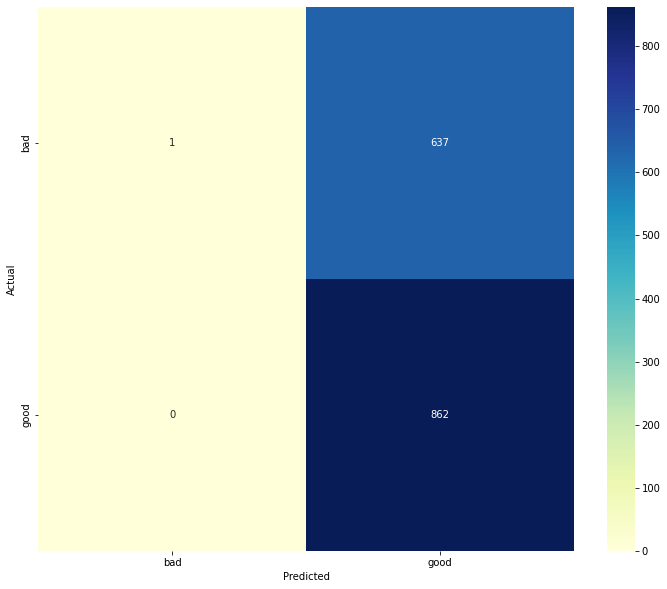

In [ ]:
# confusion matrix
class_names = ["bad", "good"]
cmat = confusion_matrix(y_test_bin, y_pred_rating)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
np.min(y_pred[0], axis=0), np.max(y_pred[0], axis=0), np.quantile(y_pred[0], q=0.5, axis=0), np.quantile(y_pred[0], q=0.6, axis=0), np.quantile(y_pred[0], q=0.7, axis=0), np.quantile(y_pred[0], q=0.9, axis=0)

(array([0.11624219, 0.09427531], dtype=float32),
 array([0.90572464, 0.8837578 ], dtype=float32),
 array([0.17543183, 0.82456818]),
 array([0.18039145, 0.83016106]),
 array([0.18564775, 0.83511286]),
 array([0.19851449, 0.85160298]))

In [ ]:
thresholds = list(np.arange(.75, .9, .01))
print(thresholds)

for thres in thresholds:
    print("\n", "-"*50)
    print(f"thres: {thres}")
    y_pred_rating = [1 if pred[1]>=thres else 0 for pred in y_pred[0]]
    print(classification_report(y_test_bin, y_pred_rating))
    

[0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.8800000000000001, 0.8900000000000001, 0.9000000000000001]

 --------------------------------------------------
thres: 0.75
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.79      0.50      0.37      1500
weighted avg       0.76      0.58      0.42      1500


 --------------------------------------------------
thres: 0.76
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       638
           1       0.58      1.00      0.73       862

    accuracy                           0.58      1500
   macro avg       0.79      0.50      0.37      1500
weighted avg       0.76      0.58      0.42      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

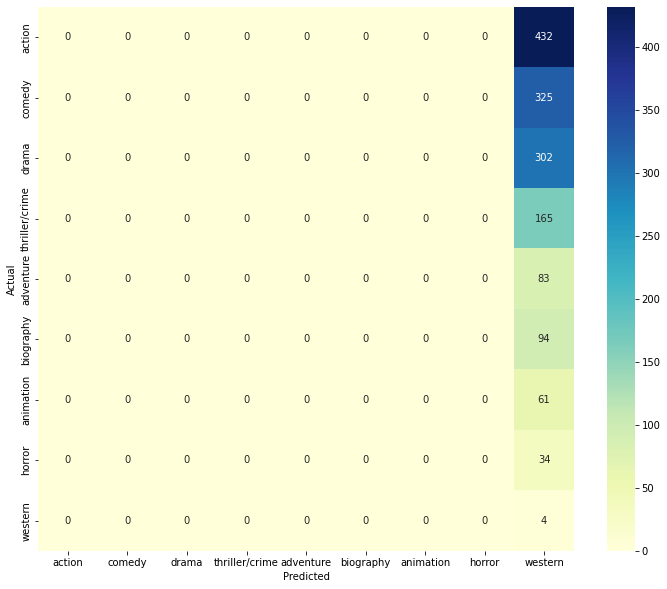

In [ ]:
# confusion matrix
class_names = list(genre2id.keys())
cmat = confusion_matrix(y_test_genre, y_pred_genre)
plt.figure(figsize=(12,10))
sns.heatmap(cmat, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## compare

### load binary model

In [ ]:
model_bin = load_model("/content/drive/MyDrive/DAI_Project/saved_models/lstm_binary_02_0.7380.h5", custom_objects={'Functional':Model})

In [ ]:
model_bin = load_model("/content/drive/MyDrive/DAI_Project/saved_models/lstm_binary_02_0.7380.h5")

In [ ]:
y_pred_bin = model_bin.predict(x_test_idx_padded)
print(y_pred_bin.shape)

y_pred_bin = np.argmax(y_pred_bin, axis=1)
y_pred_bin.shape

(1500, 2)


(1500,)

In [ ]:
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.50      0.23      0.31       638
           1       0.59      0.83      0.69       862

    accuracy                           0.58      1500
   macro avg       0.55      0.53      0.50      1500
weighted avg       0.55      0.58      0.53      1500



### postive review comparision

In [ ]:
y_pred_bin = model_bin.predict(x_test_idx_padded)
y_pred_bias = model_bias_free.predict(x_test_idx_padded)
print(y_pred_bin.shape, y_pred_bias[0].shape, y_pred_bias[1].shape)

In [ ]:
cols = ['movie', 'rating', 'genre_primary_mapped', 'genre_label', 'review_title', 'review', 'review_processed', 'num_tokens', 'review_rating', 'review_class_bin']
df_comp = df_test[cols].copy()
df_comp.head()

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin
970,Dangal,8.3,action,0,Dangal is unmissable.,Dangal review :In his 2001 Oscar nominated 'La...,dangal unmissable dangal review in 2001 oscar ...,405,9/10,good
6279,Dor,7.8,drama,2,Simple and entertaining,"Right from his debut, Hyderabad Blues, Kukunoo...",simple entertaining right from debut hyderabad...,369,6/10,bad
1859,Poove Unakkaga,7.9,comedy,1,Poovae unakaga,Vijay's first blockbuster movie and superb act...,poovae unakaga vijays first blockbuster movie ...,16,10/10,good
6803,Daddy Day Camp,3.5,comedy,1,4,I would say it was below average like 4. It wa...,4 would say below average like 4 wasnt worst b...,13,4/10,bad
6305,Anjaam Pathiraa,7.8,thriller/crime,3,Deviated mold from Midhun.,I was surprised because I can't expect this ki...,deviated mold from midhun surprised because ca...,61,7/10,good


In [ ]:
df_comp["positive_prob"] = [round(pred[1], 2) for pred in y_pred_bin]
df_comp["bias_free_positive_prob"] = [round(pred[1], 2) for pred in y_pred_bias[0]]

(1500, 2) (1500, 2) (1500, 9)


In [ ]:
df_comp[df_comp.review_rating == "7/10"][:5]

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,positive_prob,bias_free_positive_prob
6305,Anjaam Pathiraa,7.8,thriller/crime,3,Deviated mold from Midhun.,I was surprised because I can't expect this ki...,deviated mold from midhun surprised because ca...,61,7/10,good,0.57,0.63
3039,In the Name of the King: A Dungeon Siege Tale,3.9,action,0,One of Uwe Boll's Better Forays into Film-maki...,"""Alone in the Dark"" director Uwe Boll's PG-13 ...",one of uwe bolls better forays into film makin...,507,7/10,good,0.77,0.66
5199,Earth,7.6,drama,2,Earth - did Deepa do it again?,1947 Earth is a story about the partition of I...,earth did deepa do again 1947 earth story abou...,318,7/10,good,0.44,0.67
6027,Batman Begins,8.2,action,0,A vast improvement over the Batman films of th...,"I enjoyed the film BATMAN from Tim Burton, tho...",vast improvement over batman films of 1990s en...,202,7/10,good,0.69,0.67
7141,Queen,8.1,adventure,4,"Finally, an Indian film that lives up to the hype",My experience with Indian cinema has been fair...,finally indian film lives up to hype experienc...,101,7/10,good,0.83,0.65


In [ ]:
df_comp[df_comp.review_rating == "8/10"].sample(5)

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,positive_prob,bias_free_positive_prob
1593,The Elephant Man,8.1,biography,5,One of Us.,This has to be the only totally straight movie...,one of us has to only totally straight movie d...,743,8/10,good,0.66,0.65
4623,The Kid,8.2,comedy,1,Sensitive and enjoyable film in which Chaplin ...,"Wonderful picture mixes sentiment , drama , sl...",sensitive enjoyable film in chaplin meets stre...,335,8/10,good,0.66,0.65
6998,Chhichhore,8.1,comedy,1,One-Line Review: Chhichhore (8 Stars),"Nitesh Tiwari's Chhichhore (Loafers), although...",one line review chhichhore 8 stars nitesh tiwa...,53,8/10,good,0.74,0.66
1672,Bhaag Milkha Bhaag,8.1,biography,5,Milkha Singh Has Won. So Has The Biographical ...,"In less than ten minutes into the film, you ge...",milkha singh has won so has biographical film ...,237,8/10,good,0.85,0.67
4147,Malik,7.9,action,0,"Another best from Mahesh Narayanan, Fahadh Faazil",Superb movie from Mollywood. Made justice to t...,another best from mahesh narayanan fahadh faaz...,27,8/10,good,0.51,0.66


In [ ]:
df_comp[df_comp.review_rating == "9/10"][:5]

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,positive_prob,bias_free_positive_prob
970,Dangal,8.3,action,0,Dangal is unmissable.,Dangal review :In his 2001 Oscar nominated 'La...,dangal unmissable dangal review in 2001 oscar ...,405,9/10,good,0.66,0.62
3504,Angoor,8.2,comedy,1,One of Bollywood's finest comedies,Bollywood comedies are normally associated wit...,one of bollywoods finest comedies bollywood co...,268,9/10,good,0.85,0.65
6636,Kai Po Che,7.7,drama,2,Satire on the existing state of affairs in India,Three friends find their lives strangled as th...,satire on existing state of affairs in india t...,80,9/10,good,0.44,0.67
3014,Talvar,8.1,thriller/crime,3,As Good as a Movie About a Real-Life Legal Cas...,Reviewed by: Dare Devil Kid (DDK)Rating: 4.3/5...,as good as movie about real life legal case ca...,353,9/10,good,0.78,0.66
3481,Kirik Party,7.9,comedy,1,A treat for all college students,This is one of the best movies i watched in re...,treat for all college students one of best mov...,71,9/10,good,0.77,0.64


In [ ]:
df_comp[df_comp.review_rating == "10/10"][:5]

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,positive_prob,bias_free_positive_prob
1859,Poove Unakkaga,7.9,comedy,1,Poovae unakaga,Vijay's first blockbuster movie and superb act...,poovae unakaga vijays first blockbuster movie ...,16,10/10,good,0.44,0.64
7194,Mahanati,8.2,biography,5,Mahanati - The Greatest Biopic Ever Made In Th...,"To be frank, I've no expectations over this fi...",mahanati greatest biopic ever made in history ...,118,10/10,good,0.69,0.64
1850,Don,7.7,action,0,AB is the best!!!,This is another classic movie by Bachchan. The...,ab best another classic movie by bachchan rang...,88,10/10,good,0.87,0.64
429,Ghilli,7.7,action,0,Such an interesting movie espically Vijay's at...,Semmma semmma semmma movie to watch. Such an i...,such interesting movie espically vijays attitu...,28,10/10,good,0.62,0.66
101,Satya,8.2,action,0,One of the most intelligent movies ever made a...,SATYA stands out from the normal Bollywood rom...,one of most intelligent movies ever made about...,143,10/10,good,0.86,0.66


### negative review comparision

In [ ]:
df_comp.drop(columns=["positive_prob", "bias_free_positive_prob"], inplace=True)

df_comp["negative_prob"] = [round(pred[0], 2) for pred in y_pred_bin]
df_comp["bias_free_negative_prob"] = [round(pred[0], 2) for pred in y_pred_bias[0]]

In [ ]:
df_comp[df_comp.review_rating == "2/10"].sample(5)

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,negative_prob,bias_free_negative_prob
6704,The Master of Disguise,3.6,adventure,4,Annoying and not funny at all,Pistachio Disguisey (Dana Carvey) is a waiter ...,annoying not funny at all pistachio disguisey ...,137,2/10,bad,0.39,0.35
7242,Laxmii,3.4,action,0,What kind of movie this is !!!!,The story of this movie is so bad and acting i...,kind of movie story of movie so bad acting ave...,21,2/10,bad,0.30,0.33
286,The Music Room,7.9,drama,2,The sensible review,If you are not from India and find the cast sy...,sensible review if not from india find cast sy...,468,2/10,bad,0.31,0.35
2465,Dabangg 3,3.7,action,0,Exaggerated with tons of overacting ....,Move on ...Nothing new to watch here. The nove...,exaggerated with tons of overacting move on no...,54,2/10,bad,0.27,0.37
1595,The Love Guru,3.9,comedy,1,Mike Myers hits a new low!,The Love Guru is another stupid comedy written...,mike myers hits new low love guru another stup...,182,2/10,bad,0.25,0.35


In [ ]:
df_comp[df_comp.review_rating == "3/10"].sample(5)

,movie,rating,genre_primary_mapped,genre_label,review_title,review,review_processed,num_tokens,review_rating,review_class_bin,negative_prob,bias_free_negative_prob
2291,My Father and My Son,8.1,drama,2,An emotional drama that never hits hard,"This is an emotional drama that, after the ope...",emotional drama never hits hard emotional dram...,149,3/10,bad,0.42,0.33
7499,Dragon Wars: D-War,3.8,action,0,The monsters attacks are some of the best visu...,First off you don't see any dragons until the ...,monsters attacks some of best visuals in years...,313,3/10,bad,0.58,0.34
6356,Date Movie,2.9,comedy,1,The best of the Friedberg-Seltzer spoof movies...,You may probably remember how much I dislike F...,best of friedberg seltzer spoof movies but not...,216,3/10,bad,0.28,0.33
1940,Dragonball Evolution,2.6,action,0,"Goki , Master Roshi and Bulma battle Lord Picc...",The story starts with Goku (Justin Chatwin of ...,goki master roshi bulma battle lord piccolo to...,284,3/10,bad,0.44,0.35
3153,Daddy Day Camp,3.5,comedy,1,Daddy Day Camp,Always beware a sequel where none of the origi...,daddy day camp always beware sequel where none...,96,3/10,bad,0.22,0.35
